In [1]:
import os
import pandas as pd
import numpy as np
import joblib
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize, RobustScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model

2025-05-28 16:42:10.285128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748450530.482991      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748450530.543566      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def build_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [3]:
def train_phase(phase_path, sample=False, epochs=50, batch_size=32):
    best_model = None
    best_score = 0
    all_metrics = []

    for fold in range(1, 6):
        fold_path = os.path.join(phase_path, f"fold{fold}")

        if sample:
            scaler = joblib.load(f"{fold_path}/scaler.pkl")
            X_train = pd.read_csv(f"{fold_path}/X_train_resampled.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train_resampled.csv").values.ravel()
        else:
            X_train = pd.read_csv(f"{fold_path}/X_train.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train.csv").values.ravel()
            scaler = RobustScaler()
            X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

        X_val = pd.read_csv(f"{fold_path}/X_val.csv")
        y_val = pd.read_csv(f"{fold_path}/y_val.csv").values.ravel()
        X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)

        num_classes = len(np.unique(y_train))
        y_train_cat = to_categorical(y_train, num_classes=num_classes)
        y_val_cat = to_categorical(y_val, num_classes=num_classes)

        X_train_reshaped = np.expand_dims(X_train.values, axis=2)
        X_val_reshaped = np.expand_dims(X_val.values, axis=2)

        model = build_cnn_model(input_shape=X_train_reshaped.shape[1:], num_classes=num_classes)

        early_stop = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')
        model.fit(X_train_reshaped, y_train_cat, validation_data=(X_val_reshaped, y_val_cat),
                  epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stop])

        y_pred_probs = model.predict(X_val_reshaped)
        y_pred = np.argmax(y_pred_probs, axis=1)

        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='macro')
        auc = roc_auc_score(to_categorical(y_val), y_pred_probs, average='macro', multi_class='ovr')

        all_metrics.append({'fold': fold, 'accuracy': acc, 'f1_macro': f1, 'auc': auc})

        if f1 > best_score:
            best_score = f1
            best_model = model
            best_scaler = scaler
            best_fold = fold

        print(f"\nFold {fold} Classification Report:\n", classification_report(y_val, y_pred))

        cm = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 6))
        for i in range(num_classes):
            fpr, tpr, _ = roc_curve(to_categorical(y_val)[:, i], y_pred_probs[:, i])
            plt.plot(fpr, tpr, label=f'Class {i}')
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Fold {fold}')
        plt.legend()
        plt.tight_layout()
        plt.show()

    avg_metrics = pd.DataFrame(all_metrics).mean().to_dict()
    print(f"\nAverage Accuracy: {avg_metrics['accuracy']:.4f}")
    print(f"Average F1 Macro: {avg_metrics['f1_macro']:.4f}")
    print(f"Average AUC: {avg_metrics['auc']:.4f}")

    return best_model, best_scaler, best_fold, all_metrics



======= Training Phase 1 ========



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1748450543.620173      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/50


I0000 00:00:1748450548.271545      60 service.cc:148] XLA service 0x7f6490010030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748450548.272348      60 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748450548.663944      60 cuda_dnn.cc:529] Loaded cuDNN version 90300


 58/340 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5754 - loss: 1.6726

I0000 00:00:1748450551.898811      60 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.6156 - loss: 1.2558 - val_accuracy: 0.6733 - val_loss: 0.8413
Epoch 2/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6674 - loss: 0.8544 - val_accuracy: 0.6899 - val_loss: 0.7922
Epoch 3/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6788 - loss: 0.8075 - val_accuracy: 0.6895 - val_loss: 0.7681
Epoch 4/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6867 - loss: 0.7915 - val_accuracy: 0.6980 - val_loss: 0.7521
Epoch 5/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6808 - loss: 0.7976 - val_accuracy: 0.7046 - val_loss: 0.7377
Epoch 6/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6866 - loss: 0.7697 - val_accuracy: 0.7028 - val_loss: 0.7309
Epoch 7/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6956 - loss: 0.7723 - val_accuracy: 0.7076 - val_loss: 0.7365
Epoch 8/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6892 - loss: 0.7696 - val_accuracy: 0.6998 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


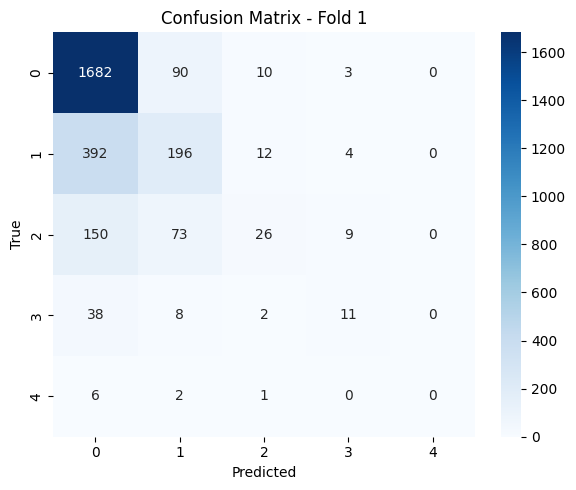

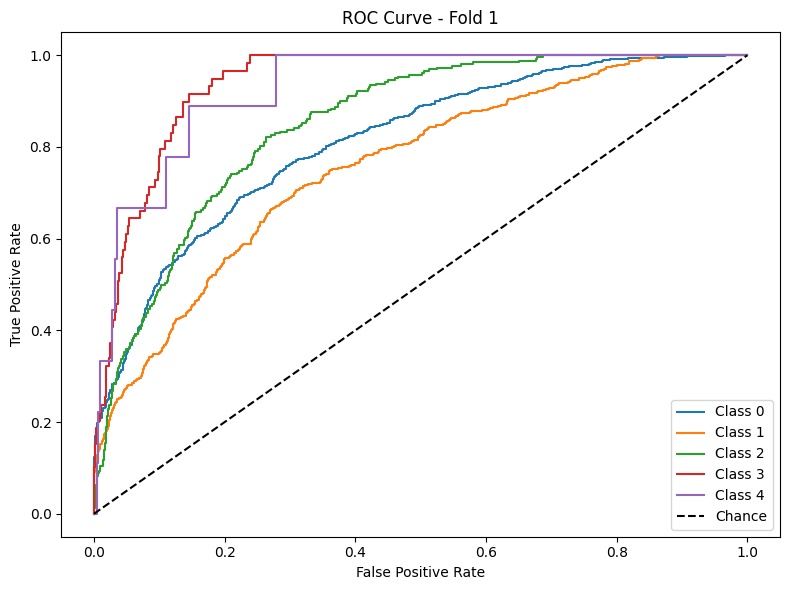

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


340/340 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.6187 - loss: 1.2520 - val_accuracy: 0.6282 - val_loss: 0.9116
Epoch 2/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6620 - loss: 0.8653 - val_accuracy: 0.6787 - val_loss: 0.8061
Epoch 3/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6754 - loss: 0.8144 - val_accuracy: 0.6875 - val_loss: 0.7799
Epoch 4/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6779 - loss: 0.7918 - val_accuracy: 0.6835 - val_loss: 0.7875
Epoch 5/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6868 - loss: 0.7799 - val_accuracy: 0.6912 - val_loss: 0.7556
Epoch 6/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6855 - loss: 0.7745 - val_accuracy: 0.6945 - val_loss: 0.7515
Epoch 7/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6897 - loss: 0.7613 - val_accuracy: 0.6957 - val_loss: 0.7502
Epoch 8/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7001 - loss: 0.7488 - val_accuracy: 0.6909 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


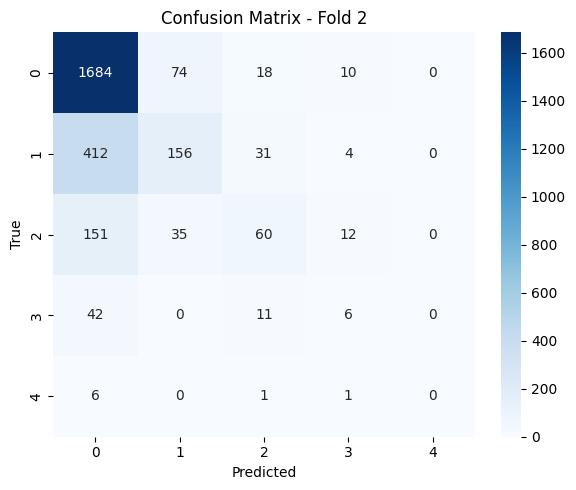

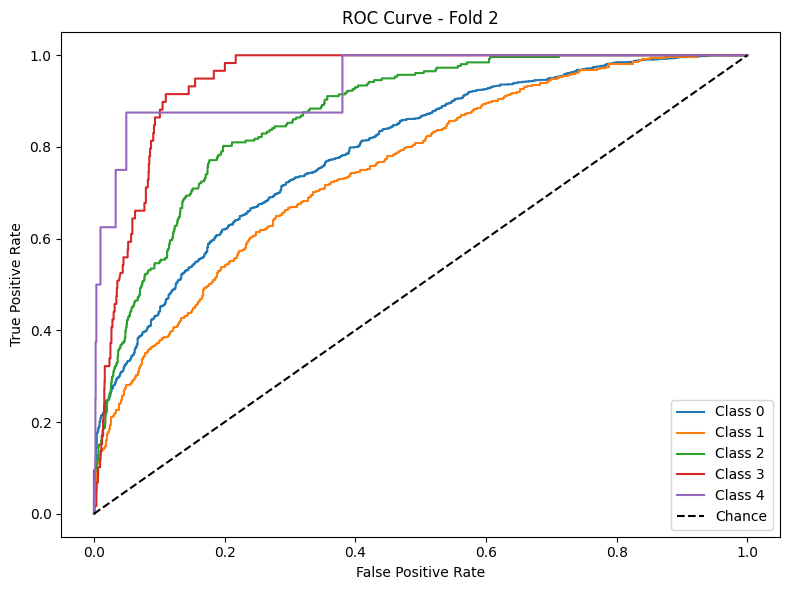

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


340/340 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6114 - loss: 1.2787 - val_accuracy: 0.6669 - val_loss: 0.8730
Epoch 2/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6730 - loss: 0.8599 - val_accuracy: 0.6805 - val_loss: 0.7817
Epoch 3/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6645 - loss: 0.8341 - val_accuracy: 0.6898 - val_loss: 0.7732
Epoch 4/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6806 - loss: 0.8119 - val_accuracy: 0.6916 - val_loss: 0.7736
Epoch 5/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6838 - loss: 0.7890 - val_accuracy: 0.6916 - val_loss: 0.7565
Epoch 6/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6789 - loss: 0.7934 - val_accuracy: 0.6990 - val_loss: 0.7406
Epoch 7/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6924 - loss: 0.7604 - val_accuracy: 0.7041 - val_loss: 0.7282
Epoch 8/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6958 - loss: 0.7637 - val_accuracy: 0.6850 - val

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


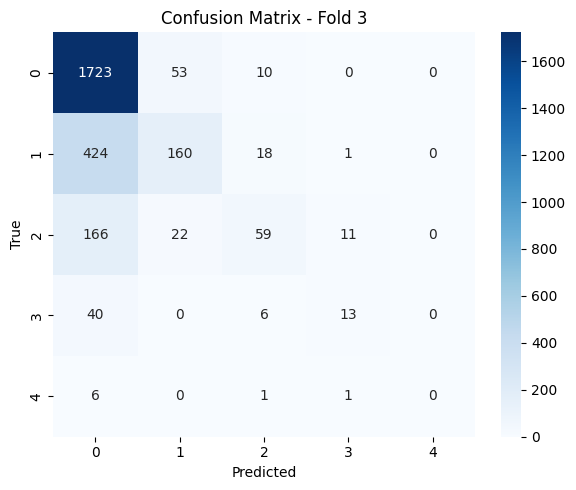

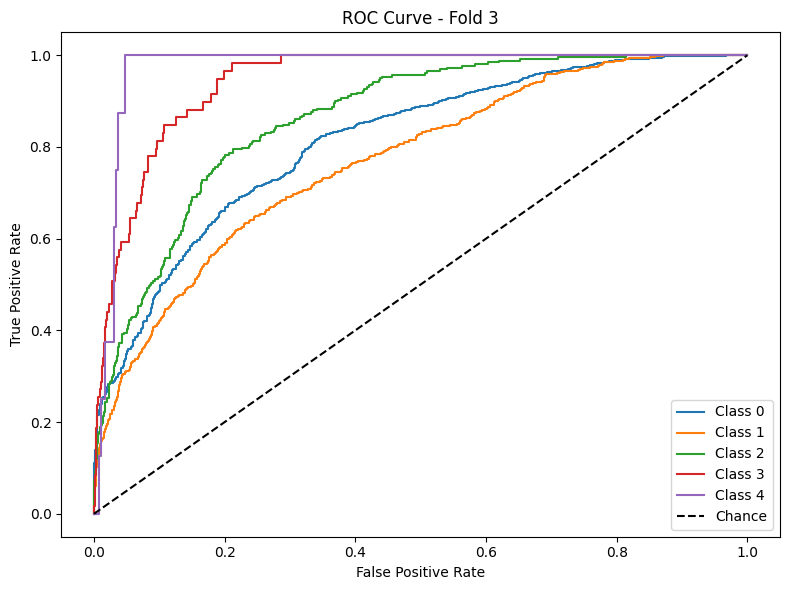

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


340/340 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6145 - loss: 1.2039 - val_accuracy: 0.6636 - val_loss: 0.8580
Epoch 2/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6558 - loss: 0.8668 - val_accuracy: 0.6964 - val_loss: 0.7704
Epoch 3/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6714 - loss: 0.8508 - val_accuracy: 0.7034 - val_loss: 0.7530
Epoch 4/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6837 - loss: 0.8084 - val_accuracy: 0.7137 - val_loss: 0.7434
Epoch 5/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6845 - loss: 0.7938 - val_accuracy: 0.7144 - val_loss: 0.7434
Epoch 6/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6849 - loss: 0.7883 - val_accuracy: 0.7141 - val_loss: 0.7277
Epoch 7/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6849 - loss: 0.7861 - val_accuracy: 0.7167 - val_loss: 0.7148
Epoch 8/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6935 - loss: 0.7622 - val_accuracy: 0.7192 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


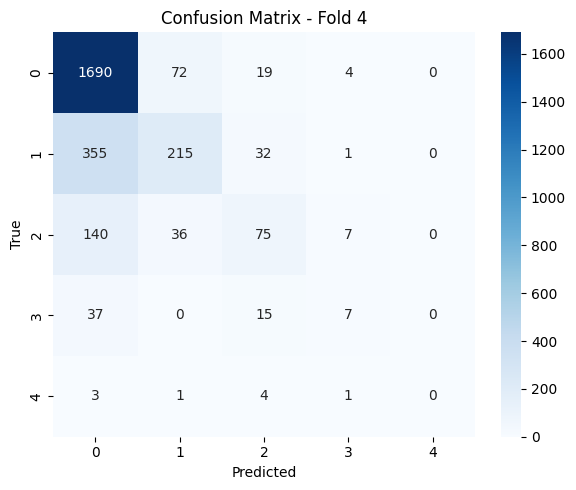

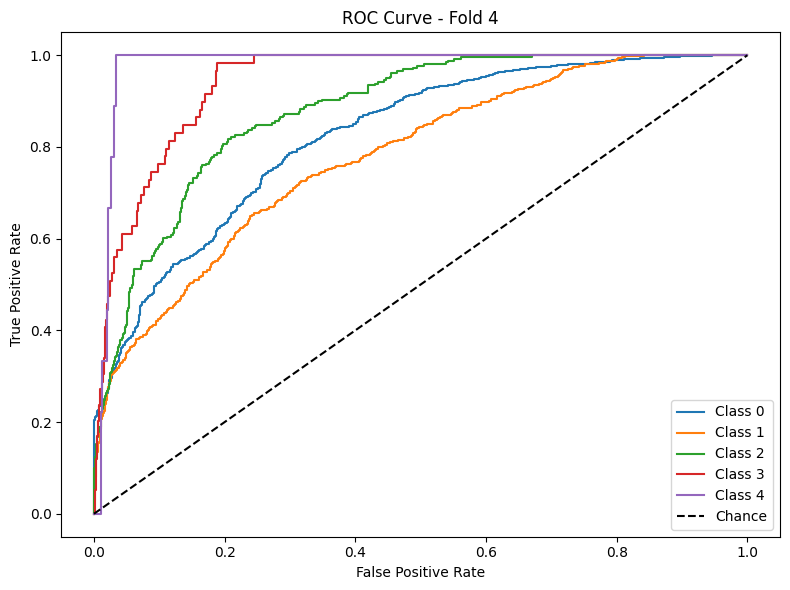

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


340/340 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6099 - loss: 1.2601 - val_accuracy: 0.6710 - val_loss: 0.9244
Epoch 2/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6617 - loss: 0.8930 - val_accuracy: 0.6614 - val_loss: 0.7963
Epoch 3/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6727 - loss: 0.8290 - val_accuracy: 0.6883 - val_loss: 0.7637
Epoch 4/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6768 - loss: 0.8081 - val_accuracy: 0.7030 - val_loss: 0.7469
Epoch 5/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6840 - loss: 0.7878 - val_accuracy: 0.6993 - val_loss: 0.7376
Epoch 6/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6852 - loss: 0.7822 - val_accuracy: 0.7060 - val_loss: 0.7444
Epoch 7/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6996 - loss: 0.7569 - val_accuracy: 0.7012 - val_loss: 0.7264
Epoch 8/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6843 - loss: 0.7743 - val_accuracy: 0.7038 - val

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


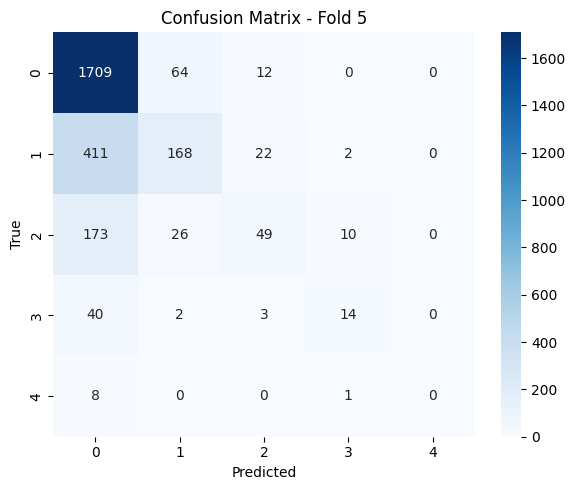

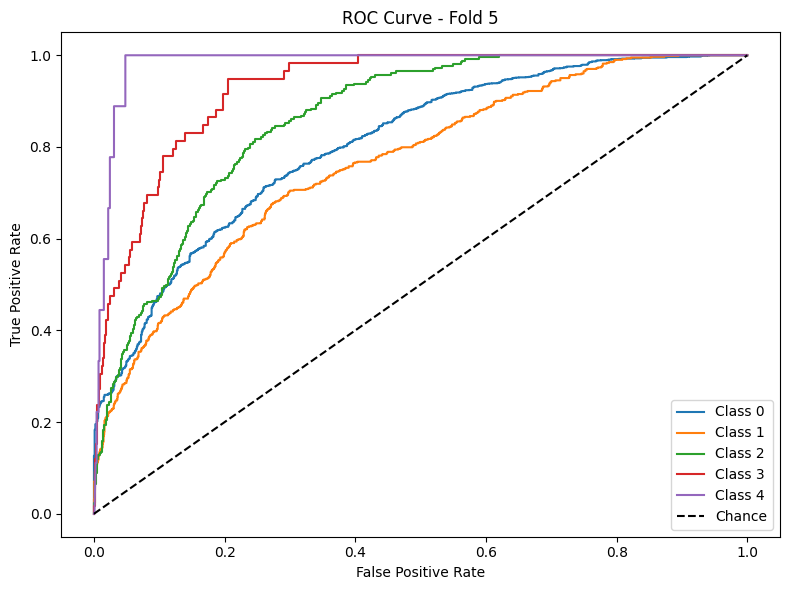


Average Accuracy: 0.7150
Average F1 Macro: 0.3531
Average AUC: 0.8677


======= Training Phase 2 ========

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


283/283 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6130 - loss: 1.3946 - val_accuracy: 0.6571 - val_loss: 0.9574
Epoch 2/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6560 - loss: 0.9323 - val_accuracy: 0.6761 - val_loss: 0.8303
Epoch 3/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6808 - loss: 0.8303 - val_accuracy: 0.6850 - val_loss: 0.7974
Epoch 4/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6685 - loss: 0.8463 - val_accuracy: 0.6796 - val_loss: 0.8041
Epoch 5/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6776 - loss: 0.8173 - val_accuracy: 0.6850 - val_loss: 0.7804
Epoch 6/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6821 - loss: 0.8049 - val_accuracy: 0.6863 - val_loss: 0.7736
Epoch 7/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6830 - loss: 0.7926 - val_accuracy: 0.6881 - val_loss: 0.7550
Epoch 8/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6828 - loss: 0.8046 - val_accuracy: 0.6894 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


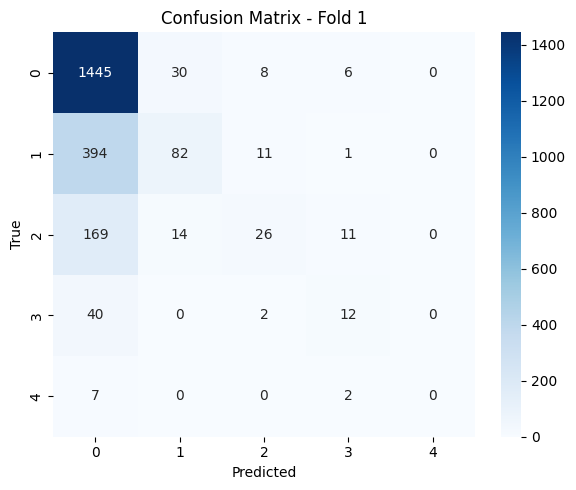

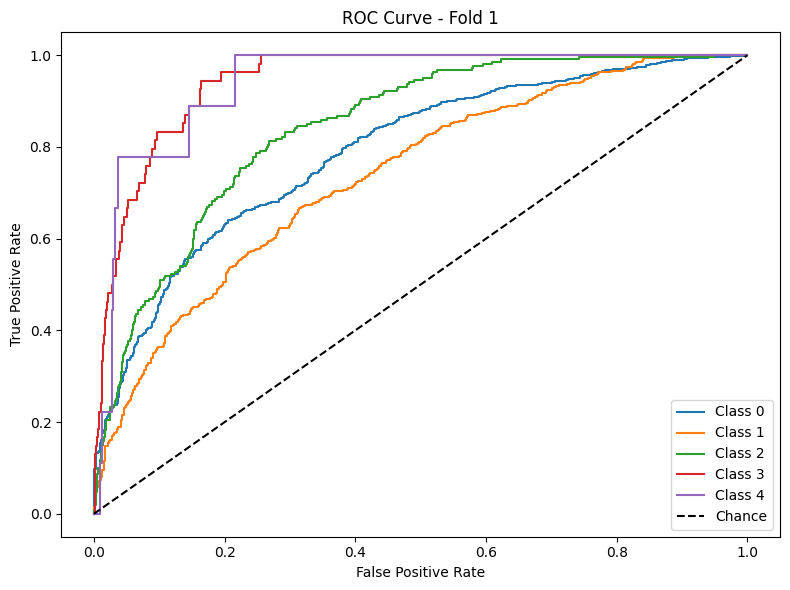

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


283/283 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5972 - loss: 1.5053 - val_accuracy: 0.6558 - val_loss: 0.9826
Epoch 2/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6586 - loss: 0.9050 - val_accuracy: 0.6637 - val_loss: 0.8604
Epoch 3/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6731 - loss: 0.8565 - val_accuracy: 0.6686 - val_loss: 0.7799
Epoch 4/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6746 - loss: 0.8348 - val_accuracy: 0.6765 - val_loss: 0.7850
Epoch 5/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6682 - loss: 0.8338 - val_accuracy: 0.6819 - val_loss: 0.7717
Epoch 6/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6683 - loss: 0.8206 - val_accuracy: 0.6783 - val_loss: 0.7637
Epoch 7/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6785 - loss: 0.7972 - val_accuracy: 0.6823 - val_loss: 0.7582
Epoch 8/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6685 - loss: 0.8118 - val_accuracy: 0.6850 - va

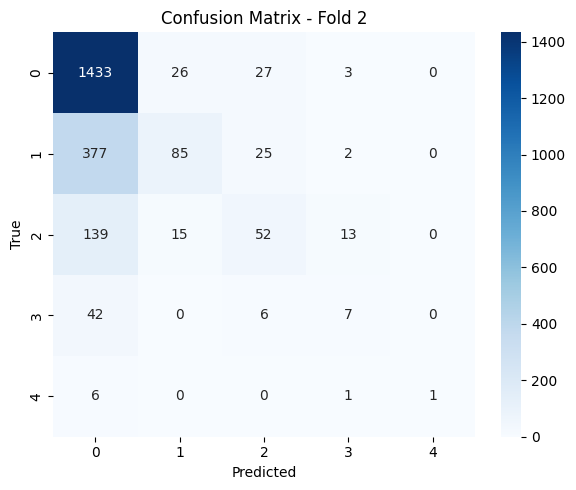

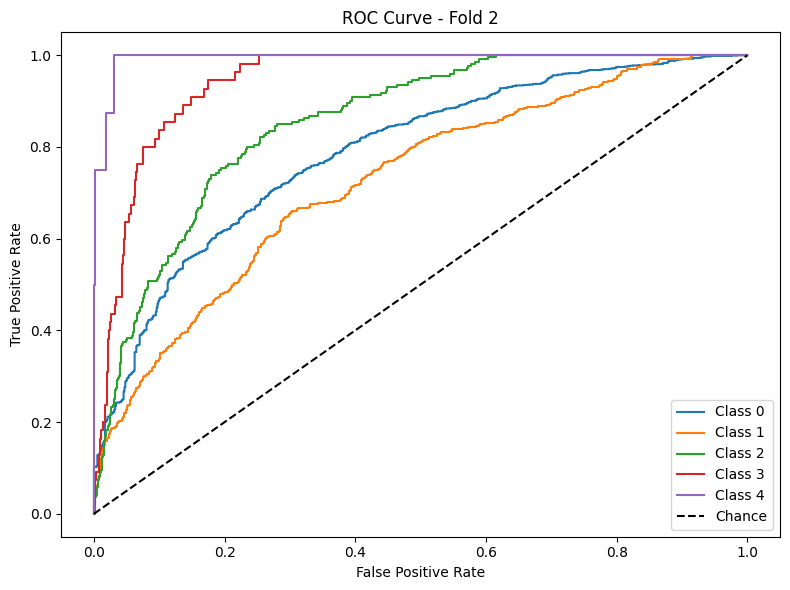

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


283/283 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.6107 - loss: 1.2977 - val_accuracy: 0.6587 - val_loss: 0.9570
Epoch 2/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6649 - loss: 0.8592 - val_accuracy: 0.6755 - val_loss: 0.8016
Epoch 3/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6721 - loss: 0.8402 - val_accuracy: 0.6618 - val_loss: 0.7926
Epoch 4/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6743 - loss: 0.8217 - val_accuracy: 0.6733 - val_loss: 0.8260
Epoch 5/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6714 - loss: 0.8059 - val_accuracy: 0.6773 - val_loss: 0.7654
Epoch 6/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6758 - loss: 0.8022 - val_accuracy: 0.6835 - val_loss: 0.7928
Epoch 7/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6780 - loss: 0.7856 - val_accuracy: 0.6857 - val_loss: 0.7594
Epoch 8/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6745 - loss: 0.7955 - val_accuracy: 0.6742 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


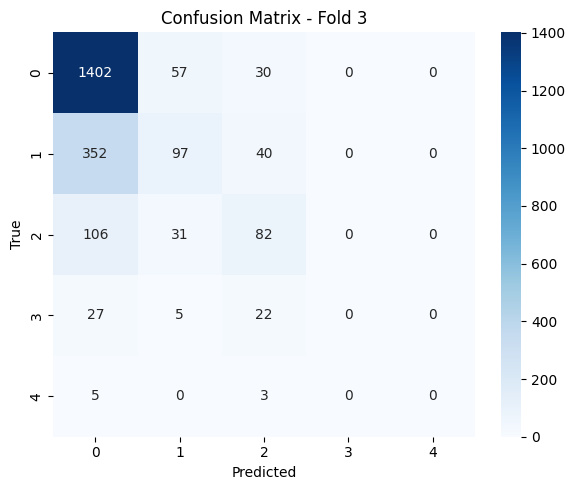

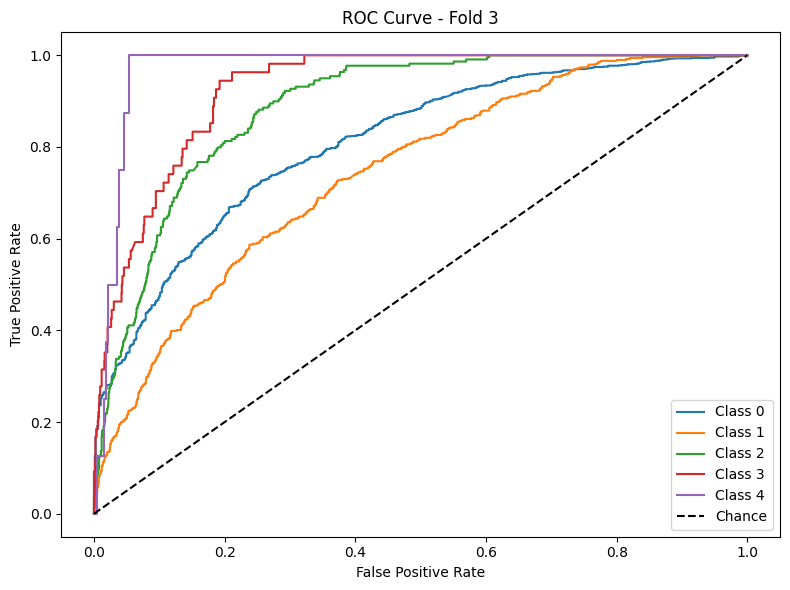

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


283/283 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.6076 - loss: 1.4979 - val_accuracy: 0.6547 - val_loss: 0.9254
Epoch 2/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6496 - loss: 0.9640 - val_accuracy: 0.6640 - val_loss: 0.8264
Epoch 3/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6612 - loss: 0.8697 - val_accuracy: 0.6826 - val_loss: 0.8101
Epoch 4/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6699 - loss: 0.8459 - val_accuracy: 0.6808 - val_loss: 0.7936
Epoch 5/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6702 - loss: 0.8343 - val_accuracy: 0.6817 - val_loss: 0.7871
Epoch 6/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6726 - loss: 0.8218 - val_accuracy: 0.6866 - val_loss: 0.7744
Epoch 7/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6738 - loss: 0.8147 - val_accuracy: 0.6870 - val_loss: 0.7723
Epoch 8/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6701 - loss: 0.8115 - val_accuracy: 0.6875 - va

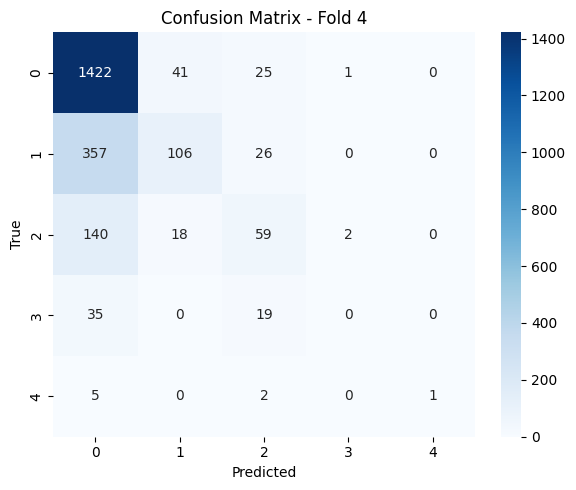

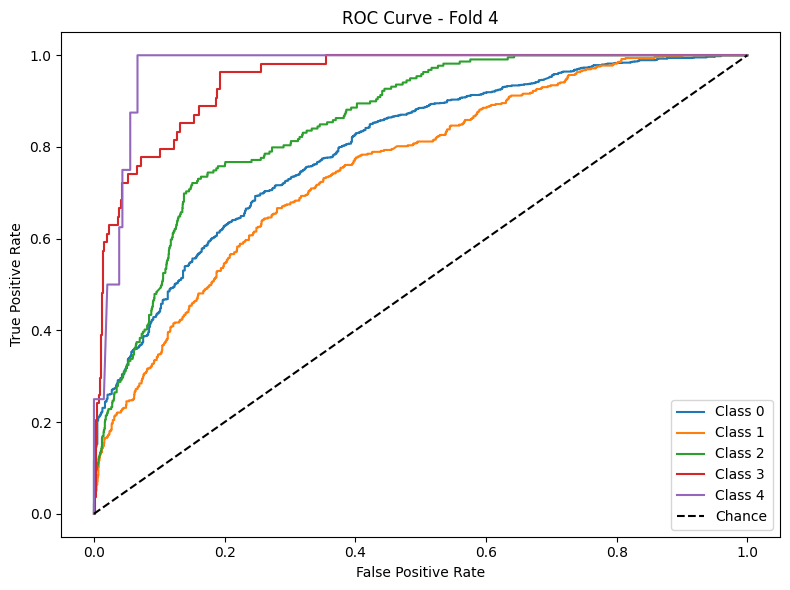

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


283/283 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6116 - loss: 1.3819 - val_accuracy: 0.6547 - val_loss: 0.9827
Epoch 2/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6623 - loss: 0.8885 - val_accuracy: 0.6662 - val_loss: 0.8179
Epoch 3/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6751 - loss: 0.8523 - val_accuracy: 0.6932 - val_loss: 0.7778
Epoch 4/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6745 - loss: 0.8364 - val_accuracy: 0.6906 - val_loss: 0.7657
Epoch 5/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6878 - loss: 0.7956 - val_accuracy: 0.6733 - val_loss: 0.7616
Epoch 6/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6780 - loss: 0.7972 - val_accuracy: 0.6888 - val_loss: 0.7533
Epoch 7/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6809 - loss: 0.7927 - val_accuracy: 0.6932 - val_loss: 0.7443
Epoch 8/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6758 - loss: 0.7895 - val_accuracy: 0.6954 - val

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


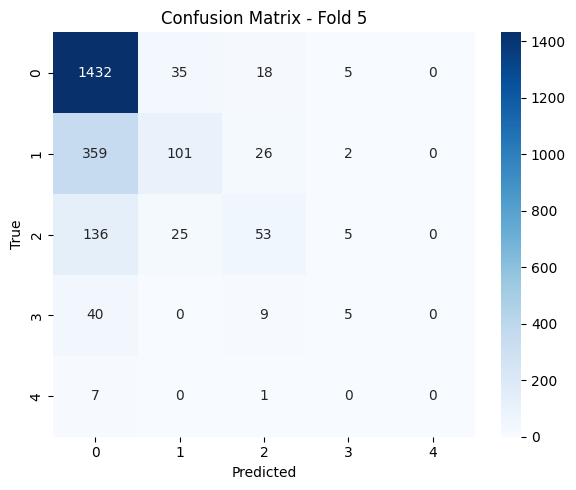

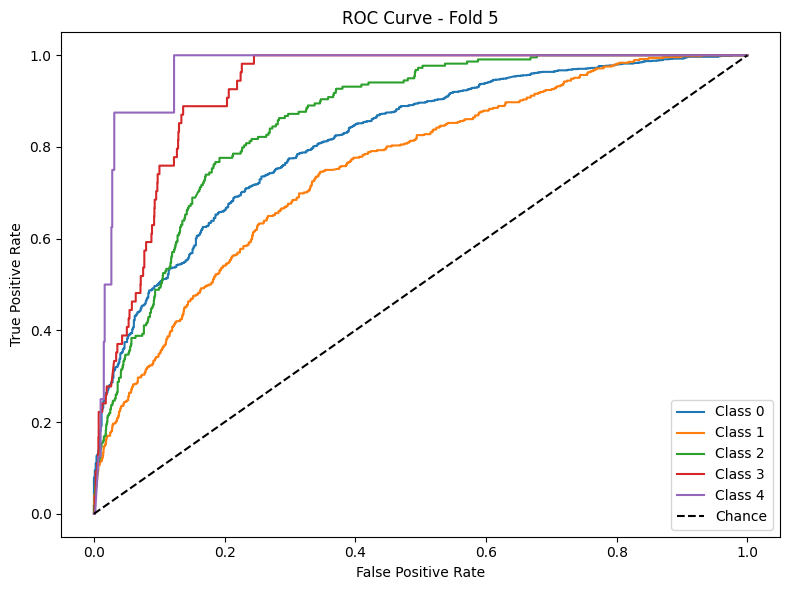


Average Accuracy: 0.6996
Average F1 Macro: 0.3283
Average AUC: 0.8617


======= Training Phase 3 ========

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.6097 - loss: 1.3862 - val_accuracy: 0.6379 - val_loss: 0.9606
Epoch 2/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6581 - loss: 0.9250 - val_accuracy: 0.6794 - val_loss: 0.8134
Epoch 3/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6655 - loss: 0.8673 - val_accuracy: 0.6789 - val_loss: 0.7763
Epoch 4/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6796 - loss: 0.8202 - val_accuracy: 0.6876 - val_loss: 0.7625
Epoch 5/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6770 - loss: 0.8229 - val_accuracy: 0.6823 - val_loss: 0.7610
Epoch 6/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6906 - loss: 0.8061 - val_accuracy: 0.6871 - val_loss: 0.7528
Epoch 7/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6865 - loss: 0.7978 - val_accuracy: 0.6871 - val_loss: 0.7378
Epoch 8/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6817 - loss: 0.7894 - val_accuracy: 0.6832 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


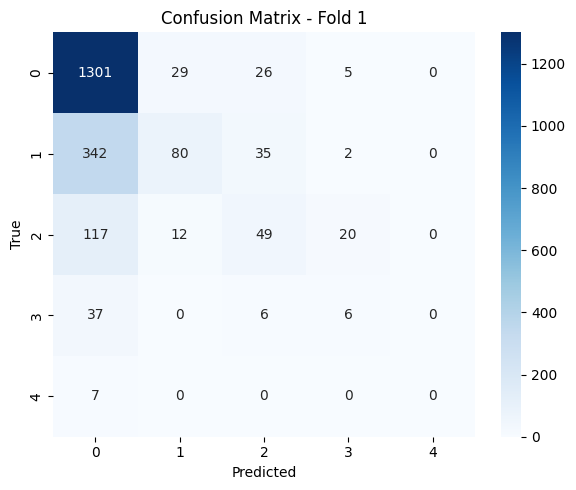

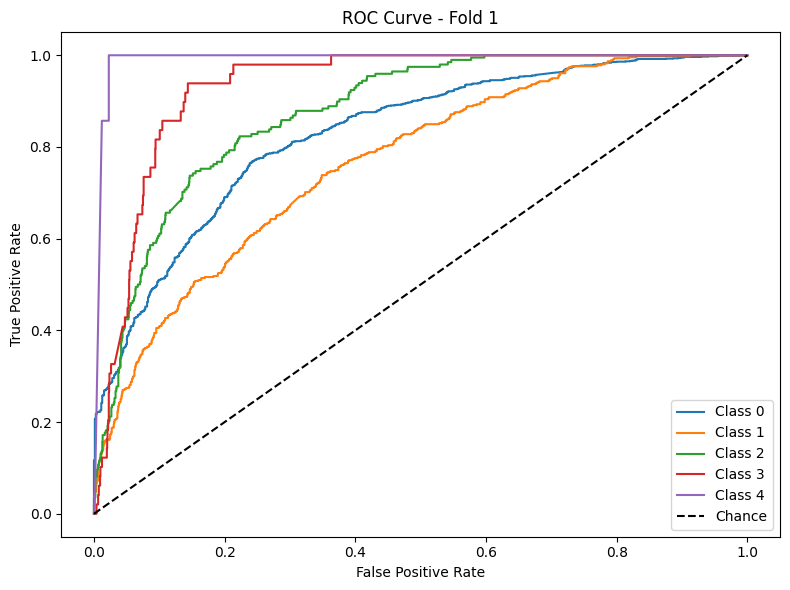

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.6046 - loss: 1.5312 - val_accuracy: 0.6649 - val_loss: 0.9822
Epoch 2/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6522 - loss: 0.9449 - val_accuracy: 0.6712 - val_loss: 0.8203
Epoch 3/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6616 - loss: 0.8727 - val_accuracy: 0.6861 - val_loss: 0.7840
Epoch 4/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6734 - loss: 0.8240 - val_accuracy: 0.6808 - val_loss: 0.7813
Epoch 5/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6734 - loss: 0.8261 - val_accuracy: 0.6876 - val_loss: 0.7561
Epoch 6/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6725 - loss: 0.8292 - val_accuracy: 0.6948 - val_loss: 0.7415
Epoch 7/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6690 - loss: 0.7998 - val_accuracy: 0.6909 - val_loss: 0.7367
Epoch 8/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6685 - loss: 0.8039 - val_accuracy: 0.6837 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


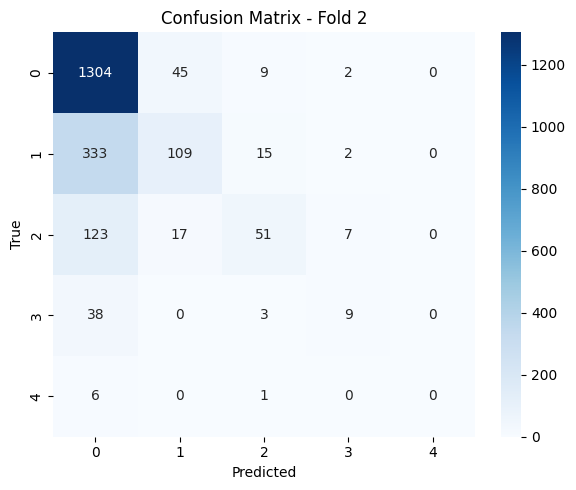

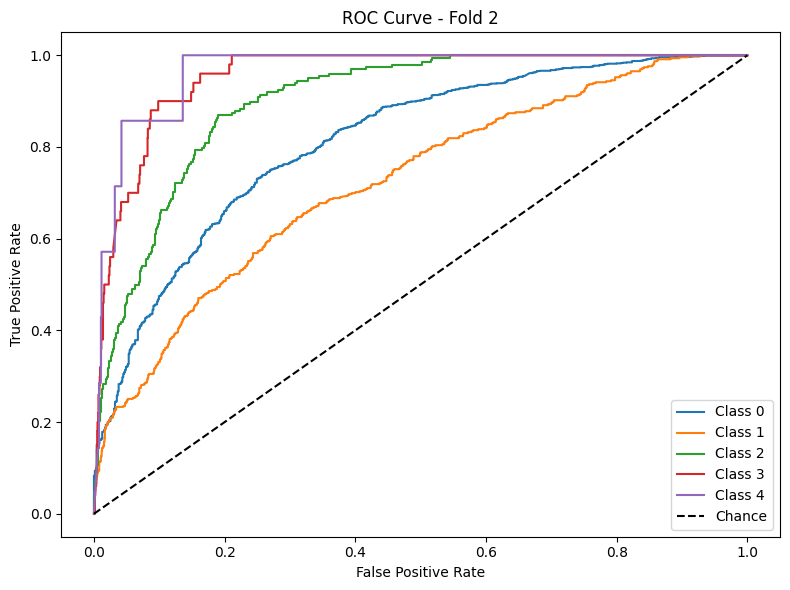

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


260/260 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.6109 - loss: 1.4877 - val_accuracy: 0.6514 - val_loss: 0.8832
Epoch 2/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6614 - loss: 0.8983 - val_accuracy: 0.6789 - val_loss: 0.8124
Epoch 3/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6677 - loss: 0.8549 - val_accuracy: 0.6851 - val_loss: 0.7829
Epoch 4/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6737 - loss: 0.8297 - val_accuracy: 0.6866 - val_loss: 0.7732
Epoch 5/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6765 - loss: 0.8194 - val_accuracy: 0.6731 - val_loss: 0.7902
Epoch 6/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6706 - loss: 0.8227 - val_accuracy: 0.6842 - val_loss: 0.7723
Epoch 7/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6733 - loss: 0.8082 - val_accuracy: 0.6856 - val_loss: 0.7617
Epoch 8/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6753 - loss: 0.8076 - val_accuracy: 0.6876 - val

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


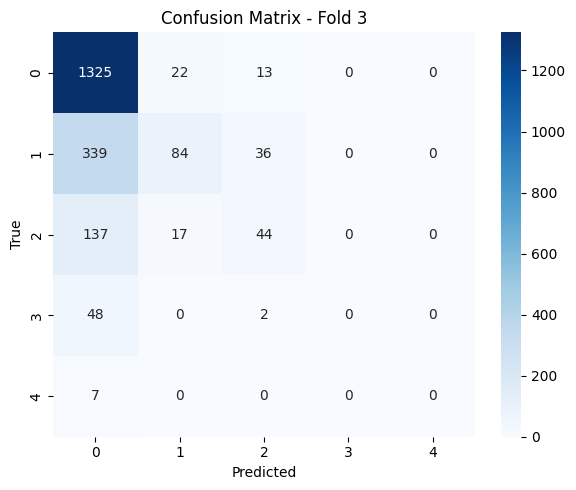

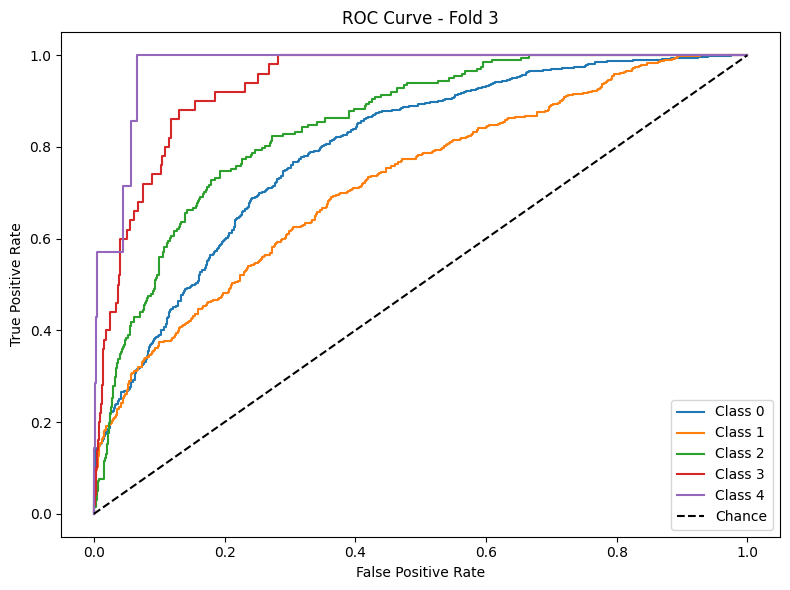

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.6018 - loss: 1.5319 - val_accuracy: 0.6442 - val_loss: 0.9415
Epoch 2/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6663 - loss: 0.9142 - val_accuracy: 0.6615 - val_loss: 0.8267
Epoch 3/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6750 - loss: 0.8431 - val_accuracy: 0.6779 - val_loss: 0.7900
Epoch 4/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6729 - loss: 0.8284 - val_accuracy: 0.6765 - val_loss: 0.8023
Epoch 5/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6734 - loss: 0.8136 - val_accuracy: 0.6789 - val_loss: 0.7873
Epoch 6/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6765 - loss: 0.8036 - val_accuracy: 0.6803 - val_loss: 0.7651
Epoch 7/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6803 - loss: 0.7854 - val_accuracy: 0.6779 - val_loss: 0.7699
Epoch 8/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6882 - loss: 0.7769 - val_accuracy: 0.6813 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


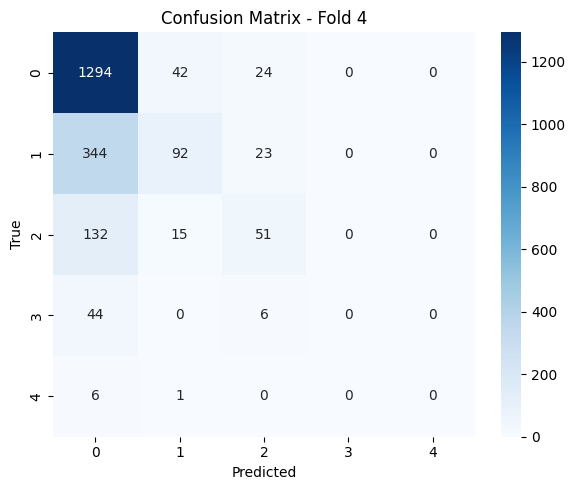

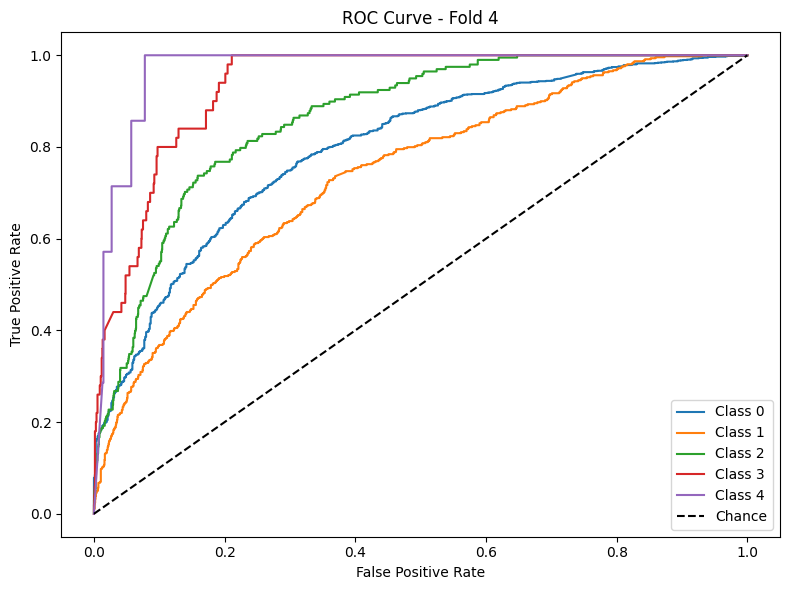

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


260/260 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.5998 - loss: 1.4710 - val_accuracy: 0.6507 - val_loss: 0.9916
Epoch 2/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6591 - loss: 0.9349 - val_accuracy: 0.6623 - val_loss: 0.8506
Epoch 3/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6731 - loss: 0.8425 - val_accuracy: 0.6836 - val_loss: 0.7840
Epoch 4/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6764 - loss: 0.8210 - val_accuracy: 0.6797 - val_loss: 0.7956
Epoch 5/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6787 - loss: 0.8106 - val_accuracy: 0.6840 - val_loss: 0.7766
Epoch 6/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6819 - loss: 0.7965 - val_accuracy: 0.6840 - val_loss: 0.7753
Epoch 7/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6776 - loss: 0.7995 - val_accuracy: 0.6807 - val_loss: 0.7809
Epoch 8/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6719 - loss: 0.7815 - val_accuracy: 0.6821 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


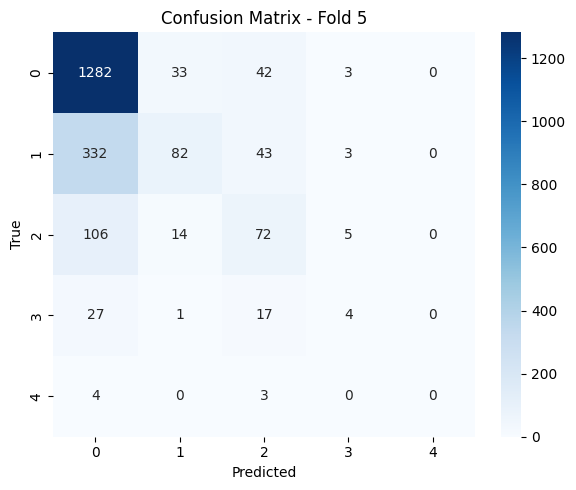

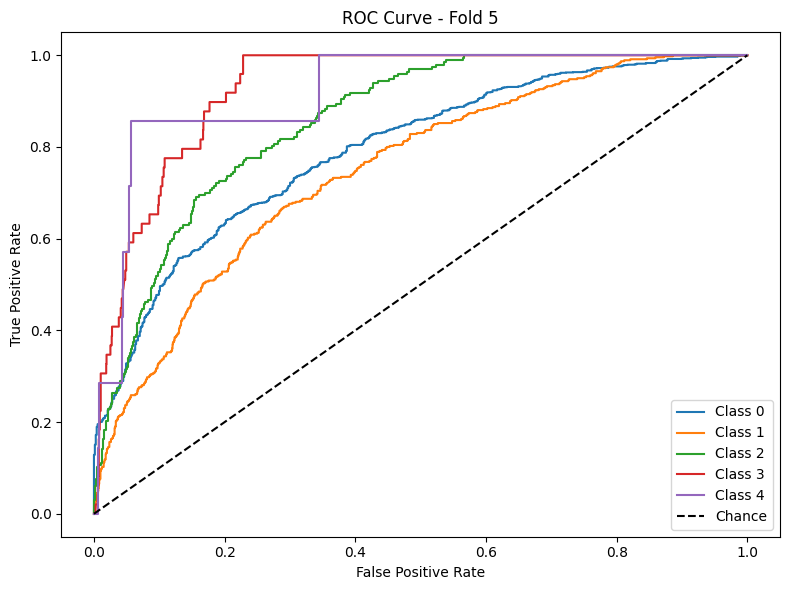


Average Accuracy: 0.6981
Average F1 Macro: 0.3132
Average AUC: 0.8632


======= Training Phase 4 ========

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


193/193 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.6066 - loss: 1.5422 - val_accuracy: 0.6550 - val_loss: 1.0052
Epoch 2/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6577 - loss: 0.9042 - val_accuracy: 0.6478 - val_loss: 0.9404
Epoch 3/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6555 - loss: 0.8550 - val_accuracy: 0.6673 - val_loss: 0.8216
Epoch 4/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6662 - loss: 0.8154 - val_accuracy: 0.6738 - val_loss: 0.8142
Epoch 5/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6684 - loss: 0.8223 - val_accuracy: 0.6725 - val_loss: 0.7862
Epoch 6/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6669 - loss: 0.8125 - val_accuracy: 0.6699 - val_loss: 0.7941
Epoch 7/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6713 - loss: 0.7904 - val_accuracy: 0.6699 - val_loss: 0.7700
Epoch 8/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6790 - loss: 0.8001 - val_accuracy: 0.6771 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


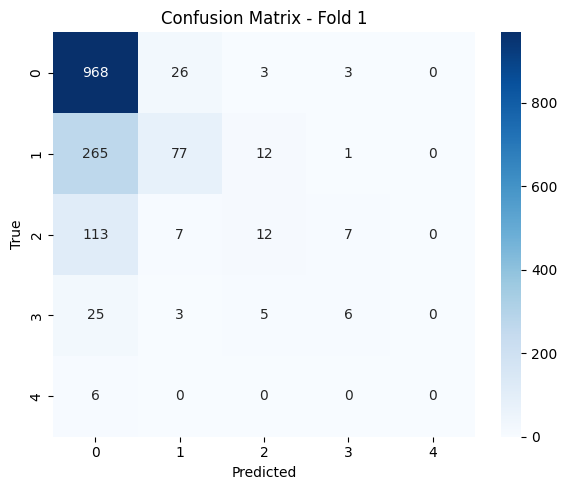

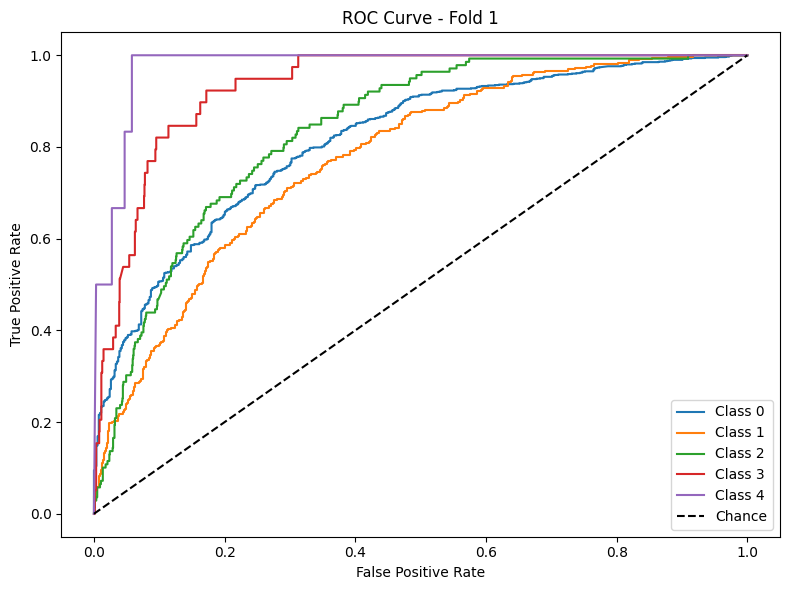

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


193/193 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.5827 - loss: 1.4838 - val_accuracy: 0.6374 - val_loss: 0.9336
Epoch 2/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6412 - loss: 0.9209 - val_accuracy: 0.6433 - val_loss: 0.8869
Epoch 3/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6596 - loss: 0.8564 - val_accuracy: 0.6719 - val_loss: 0.8392
Epoch 4/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6668 - loss: 0.8412 - val_accuracy: 0.6530 - val_loss: 0.7733
Epoch 5/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6565 - loss: 0.8323 - val_accuracy: 0.6907 - val_loss: 0.7627
Epoch 6/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6611 - loss: 0.8151 - val_accuracy: 0.6875 - val_loss: 0.7599
Epoch 7/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6740 - loss: 0.7897 - val_accuracy: 0.6686 - val_loss: 0.7623
Epoch 8/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6612 - loss: 0.8181 - val_accuracy: 0.6927 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


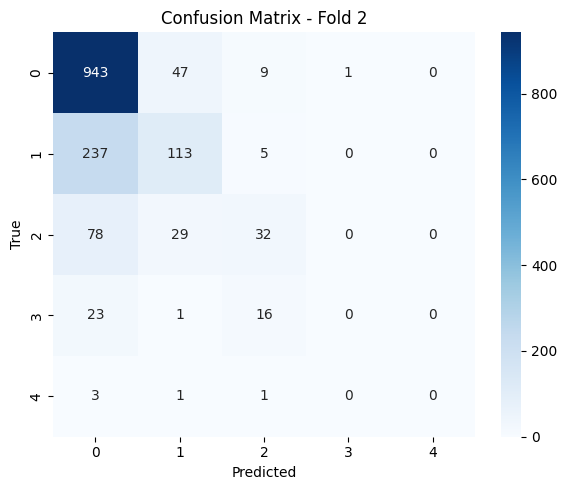

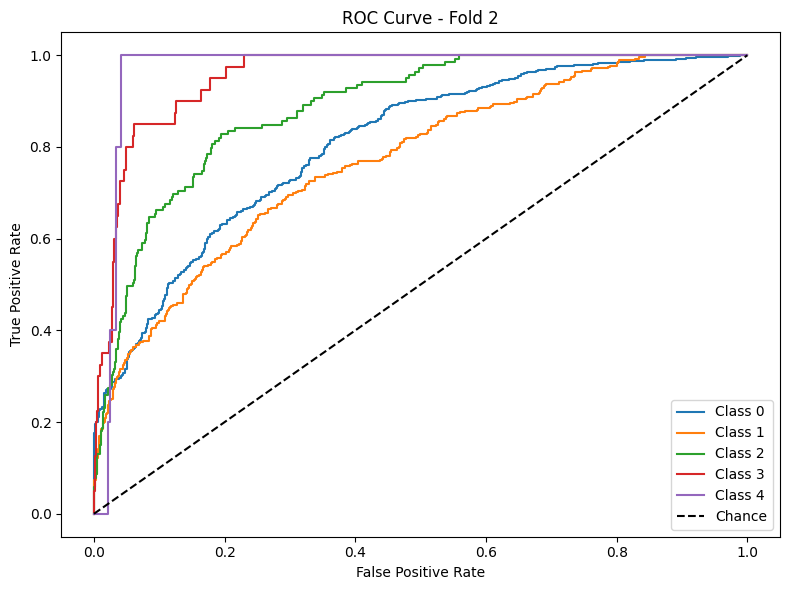

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


193/193 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.6011 - loss: 1.4622 - val_accuracy: 0.6296 - val_loss: 1.0833
Epoch 2/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6604 - loss: 0.9130 - val_accuracy: 0.6745 - val_loss: 0.9108
Epoch 3/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6564 - loss: 0.8759 - val_accuracy: 0.6712 - val_loss: 0.7900
Epoch 4/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6615 - loss: 0.8378 - val_accuracy: 0.6966 - val_loss: 0.7697
Epoch 5/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6579 - loss: 0.8352 - val_accuracy: 0.6946 - val_loss: 0.7541
Epoch 6/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6785 - loss: 0.7888 - val_accuracy: 0.6966 - val_loss: 0.7463
Epoch 7/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6742 - loss: 0.7897 - val_accuracy: 0.6985 - val_loss: 0.7535
Epoch 8/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6915 - loss: 0.7657 - val_accuracy: 0.6888 - val

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


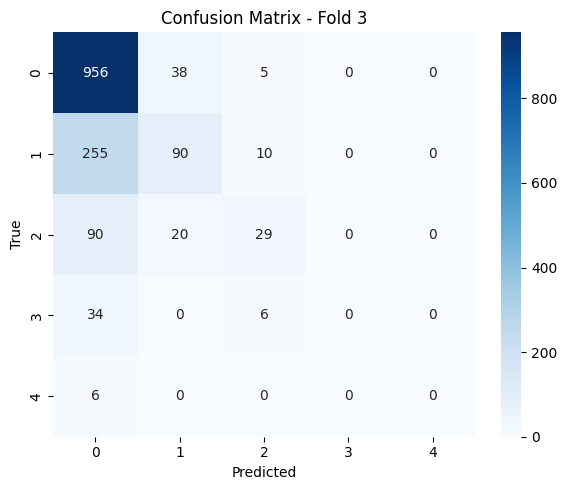

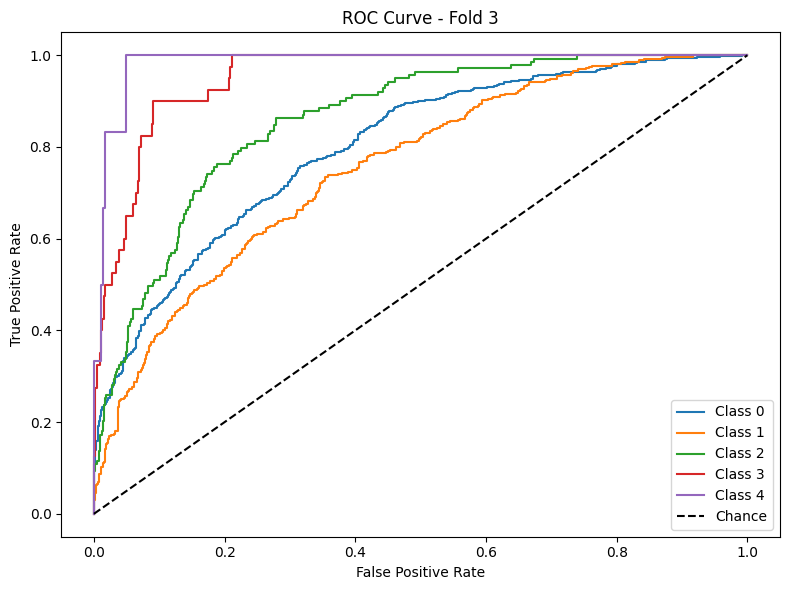

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


193/193 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.5991 - loss: 1.6352 - val_accuracy: 0.6287 - val_loss: 1.1317
Epoch 2/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6497 - loss: 0.9107 - val_accuracy: 0.6664 - val_loss: 0.8854
Epoch 3/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6511 - loss: 0.8382 - val_accuracy: 0.6678 - val_loss: 0.8566
Epoch 4/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6678 - loss: 0.8233 - val_accuracy: 0.6821 - val_loss: 0.7583
Epoch 5/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6614 - loss: 0.8217 - val_accuracy: 0.6782 - val_loss: 0.7681
Epoch 6/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6728 - loss: 0.7929 - val_accuracy: 0.6678 - val_loss: 0.7756
Epoch 7/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6624 - loss: 0.7923 - val_accuracy: 0.6762 - val_loss: 0.7533
Epoch 8/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6773 - loss: 0.7747 - val_accuracy: 0.6821 - va

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


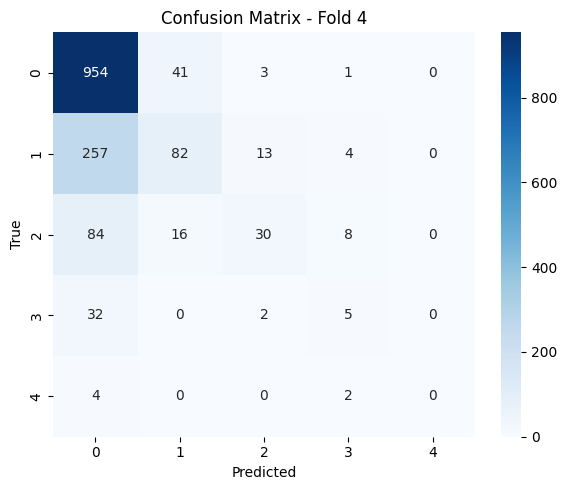

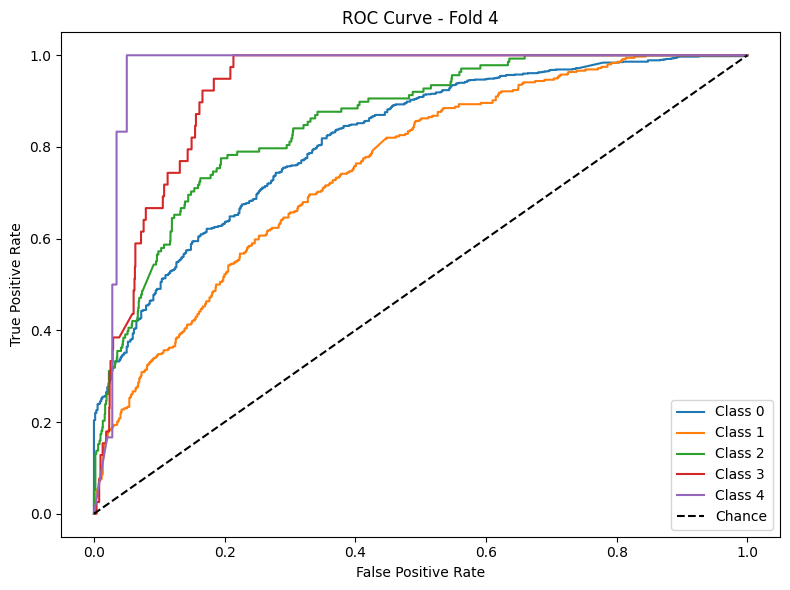

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


193/193 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.5816 - loss: 1.5481 - val_accuracy: 0.6593 - val_loss: 0.9194
Epoch 2/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6502 - loss: 0.9517 - val_accuracy: 0.6762 - val_loss: 0.8567
Epoch 3/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6620 - loss: 0.8526 - val_accuracy: 0.6808 - val_loss: 0.8279
Epoch 4/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6618 - loss: 0.8264 - val_accuracy: 0.6632 - val_loss: 0.7611
Epoch 5/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6680 - loss: 0.8011 - val_accuracy: 0.6801 - val_loss: 0.7716
Epoch 6/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6744 - loss: 0.8057 - val_accuracy: 0.6860 - val_loss: 0.7416
Epoch 7/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6694 - loss: 0.7998 - val_accuracy: 0.6886 - val_loss: 0.7478
Epoch 8/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6613 - loss: 0.8033 - val_accuracy: 0.6905 - val

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


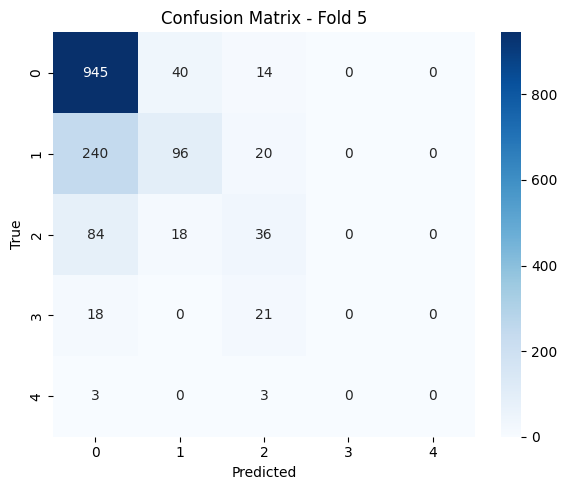

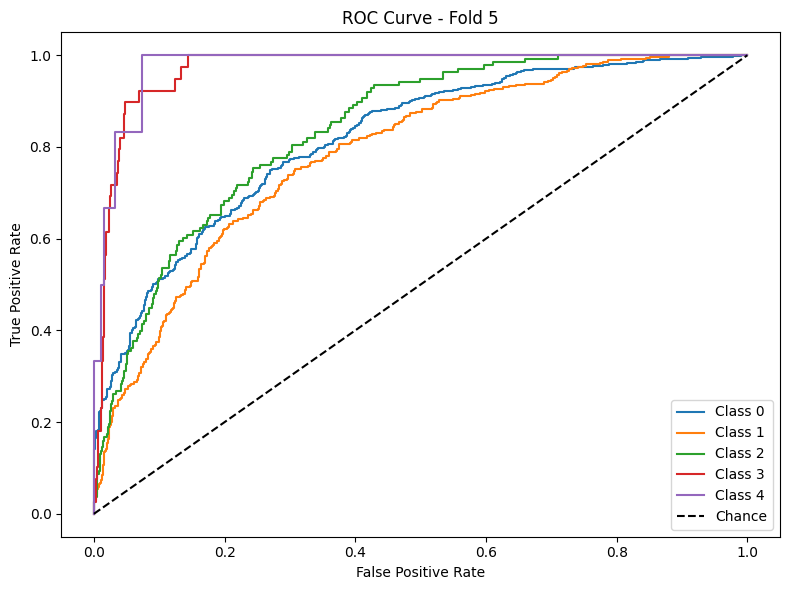


Average Accuracy: 0.6986
Average F1 Macro: 0.3077
Average AUC: 0.8712


In [4]:
# Example usage in main training loop:
phase_paths = [f"/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n===================================")
    print(f"\n======= Training Phase {i} ========")
    print(f"\n===================================")
    
    sample = False
    model, scaler, best_fold, metrics = train_phase(phase_path, sample=sample)

    temp = "sample" if sample else "no_sample"
    
    # Save CNN model (.keras) and scaler
    model.save(f"best_model_{temp}_phase{i}.keras")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    
    results[f"phase{i}"] = metrics

## Predict on Test Data

In [5]:
def predict_on_test(test_file_path, model_path, scaler_path, school_mapping_file):

    # Load model and scaler từ file
    model = load_model(model_path)
    scaler = joblib.load(scaler_path)

    # Load dữ liệu test
    df_test = pd.read_csv(test_file_path)
    y_test = df_test['label_encoded']
    X_test = df_test.drop(columns=['user_id', 'course_id', 'label_encoded', 'label', 'total_score'], axis=1)

    if 'school' in X_test.columns:
        mapping = joblib.load(school_mapping_file)
        X_test['school'] = X_test['school'].map(mapping).fillna(0).astype(int)

    X_test_scaled = scaler.transform(X_test)
    X_test_reshaped = np.expand_dims(X_test_scaled, axis=2)

    y_pred_probs = model.predict(X_test_reshaped)
    y_pred = np.argmax(y_pred_probs, axis=1)

    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    y_test_bin = to_categorical(y_test)
    auc_score = roc_auc_score(y_test_bin, y_pred_probs, average='macro', multi_class='ovr')
    print(f"\nTest AUC (macro-average, OVR): {auc_score:.4f}")

    plt.figure(figsize=(8, 6))
    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
        plt.plot(fpr, tpr, label=f'Class {i}')
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title('ROC Curves for Test Set')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return y_pred

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       568
           1       0.34      0.25      0.29        63
           2       0.29      0.12      0.17        43
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy                           0.82       698
   macro avg       0.30      0.27      0.27       698
weighted avg       0.76      0.82      0.78       698



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


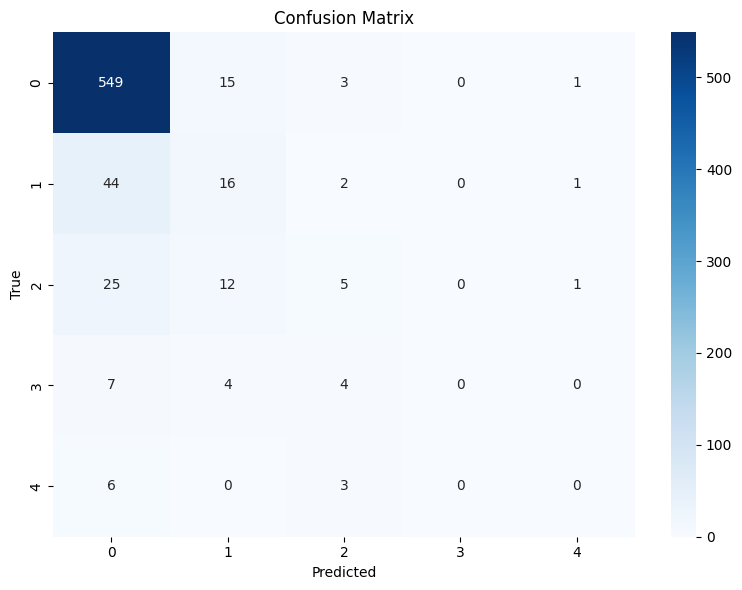


Test AUC (macro-average, OVR): 0.7873


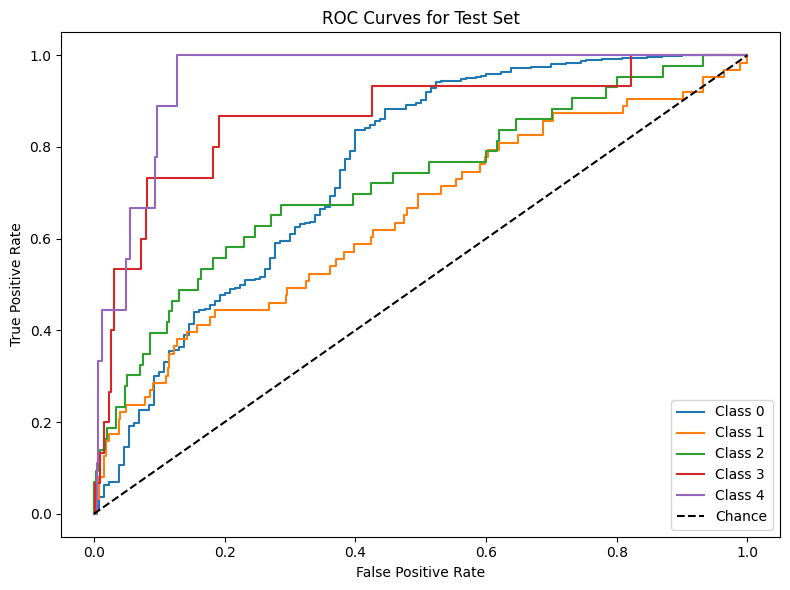

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.99      0.91       544
           1       0.25      0.03      0.06        59
           2       0.44      0.17      0.24        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.82       668
   macro avg       0.30      0.24      0.24       668
weighted avg       0.73      0.82      0.76       668



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


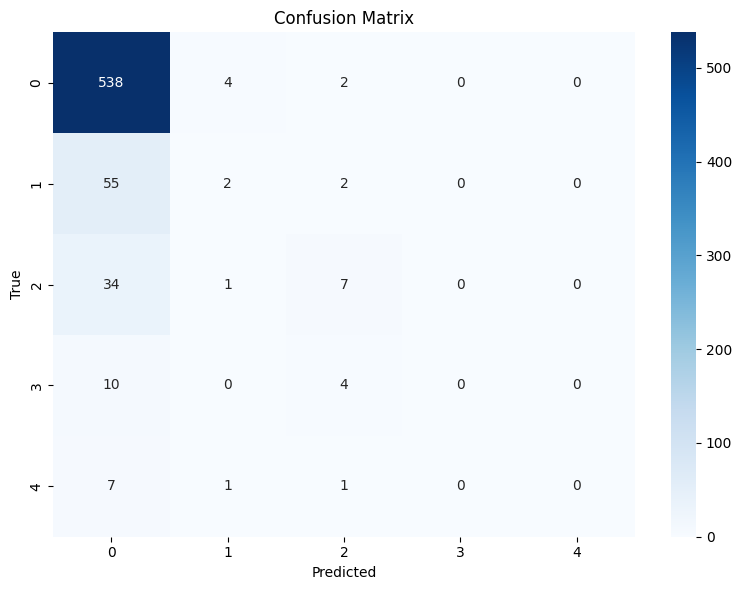


Test AUC (macro-average, OVR): 0.7812


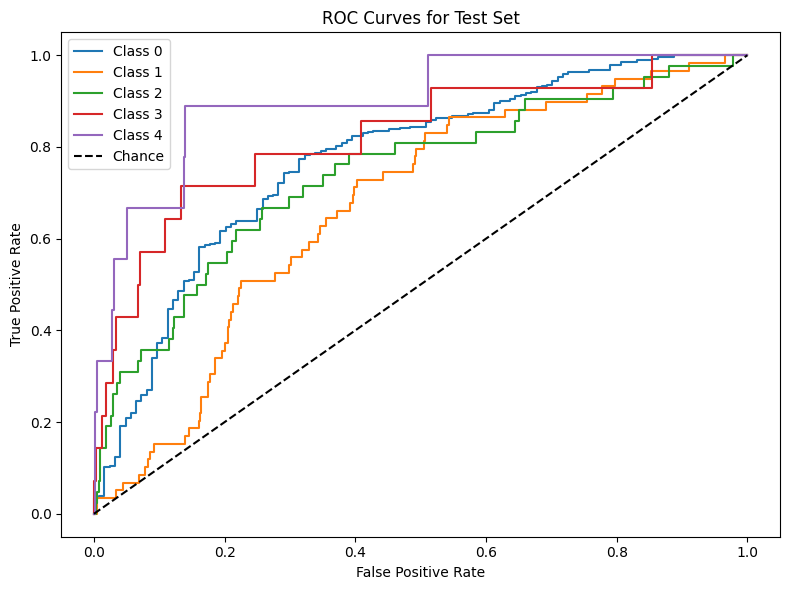

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.97      0.91       455
           1       0.31      0.17      0.22        52
           2       0.17      0.03      0.06        29
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.82       554
   macro avg       0.27      0.24      0.24       554
weighted avg       0.74      0.82      0.77       554



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


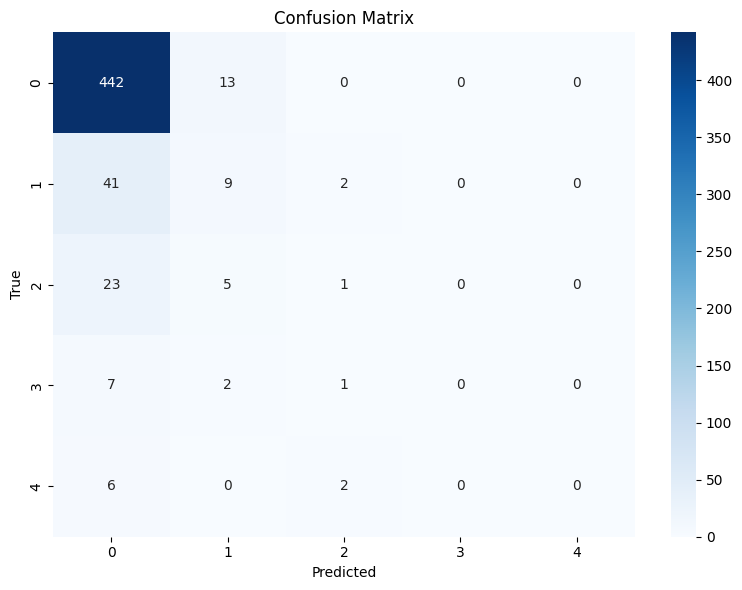


Test AUC (macro-average, OVR): 0.8187


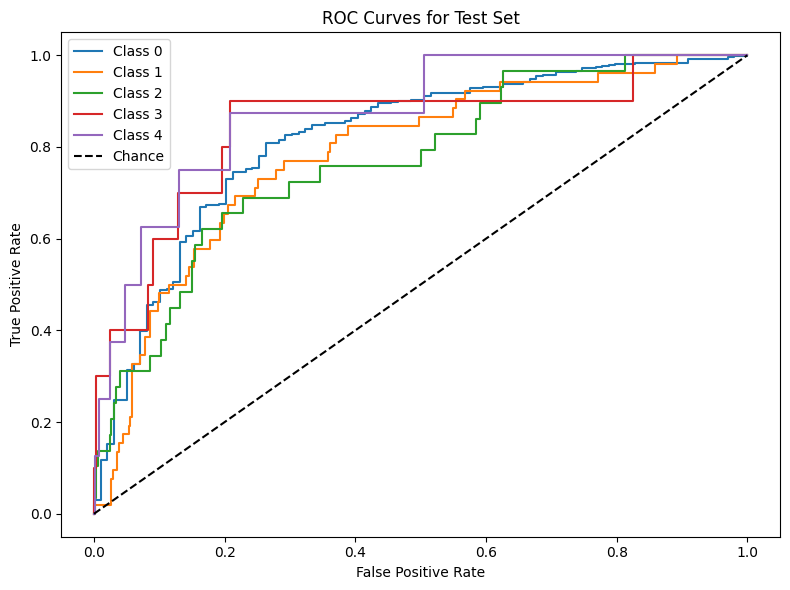

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.99      0.90       395
           1       0.20      0.03      0.04        40
           2       0.00      0.00      0.00        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.82       477
   macro avg       0.21      0.20      0.19       477
weighted avg       0.70      0.82      0.75       477



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


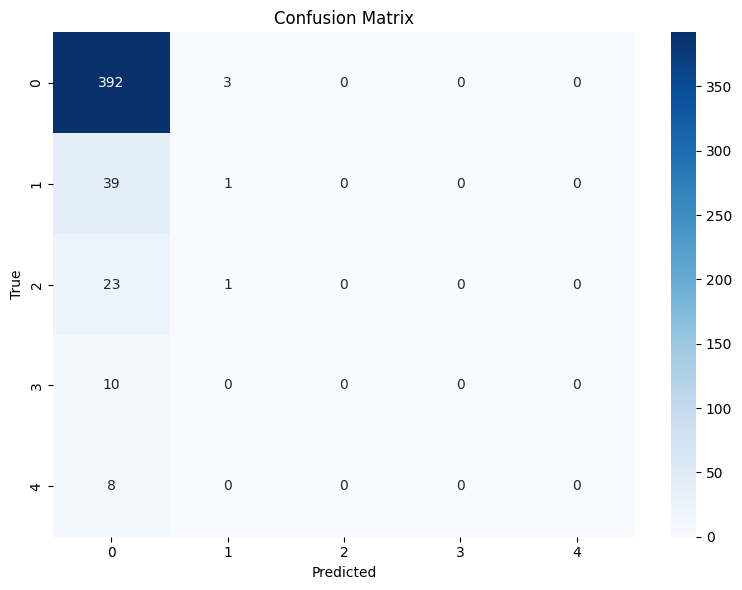


Test AUC (macro-average, OVR): 0.7257


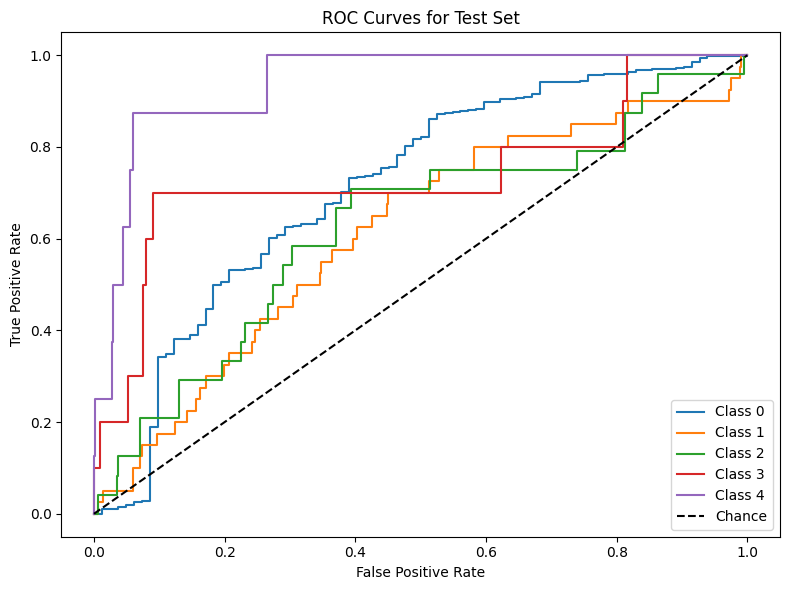

In [6]:
for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-using-node2vector/phase{i}/user_train_phase_{i}_test.csv'
    
    # Keras model
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.keras'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)

# Sample


=== Training Phase 1 ===
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


987/987 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5576 - loss: 1.2719 - val_accuracy: 0.5057 - val_loss: 1.1050
Epoch 2/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6604 - loss: 0.8566 - val_accuracy: 0.5138 - val_loss: 1.0632
Epoch 3/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6662 - loss: 0.8307 - val_accuracy: 0.5912 - val_loss: 0.9799
Epoch 4/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6862 - loss: 0.7878 - val_accuracy: 0.5783 - val_loss: 0.9772
Epoch 5/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6884 - loss: 0.7796 - val_accuracy: 0.5761 - val_loss: 0.9972
Epoch 6/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6970 - loss: 0.7558 - val_accuracy: 0.5425 - val_loss: 1.0667
Epoch 7/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6964 - loss: 0.7603 - val_accuracy: 0.6018 - val_loss: 0.9580
Epoch 8/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6958 - loss: 0.7542 - val_accuracy: 0.5934 - val_

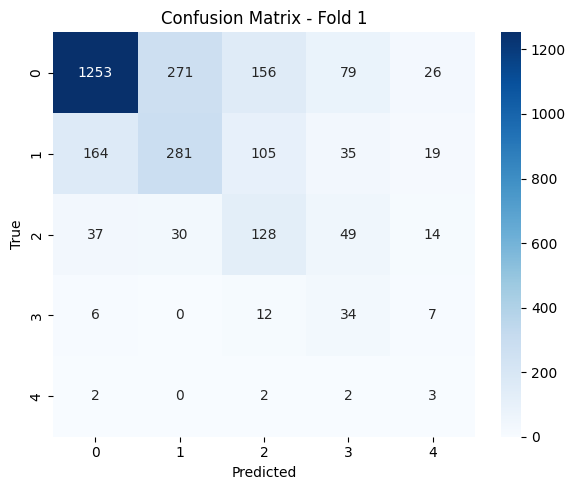

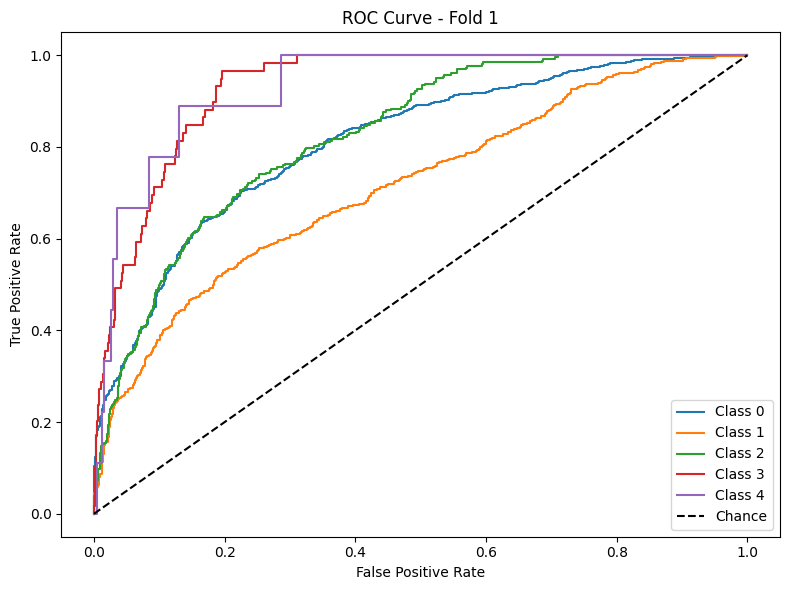

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


987/987 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.5790 - loss: 1.2249 - val_accuracy: 0.5055 - val_loss: 1.0599
Epoch 2/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6655 - loss: 0.8324 - val_accuracy: 0.5420 - val_loss: 1.0454
Epoch 3/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6818 - loss: 0.7945 - val_accuracy: 0.5490 - val_loss: 1.0160
Epoch 4/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6848 - loss: 0.7805 - val_accuracy: 0.5553 - val_loss: 0.9975
Epoch 5/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6909 - loss: 0.7727 - val_accuracy: 0.5744 - val_loss: 0.9453
Epoch 6/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6948 - loss: 0.7524 - val_accuracy: 0.5420 - val_loss: 1.0135
Epoch 7/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7043 - loss: 0.7444 - val_accuracy: 0.5785 - val_loss: 1.0114
Epoch 8/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7075 - loss: 0.7345 - val_accuracy: 0.5597 - val

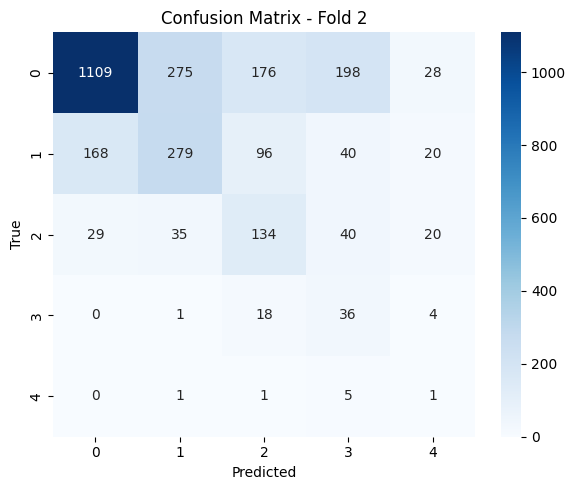

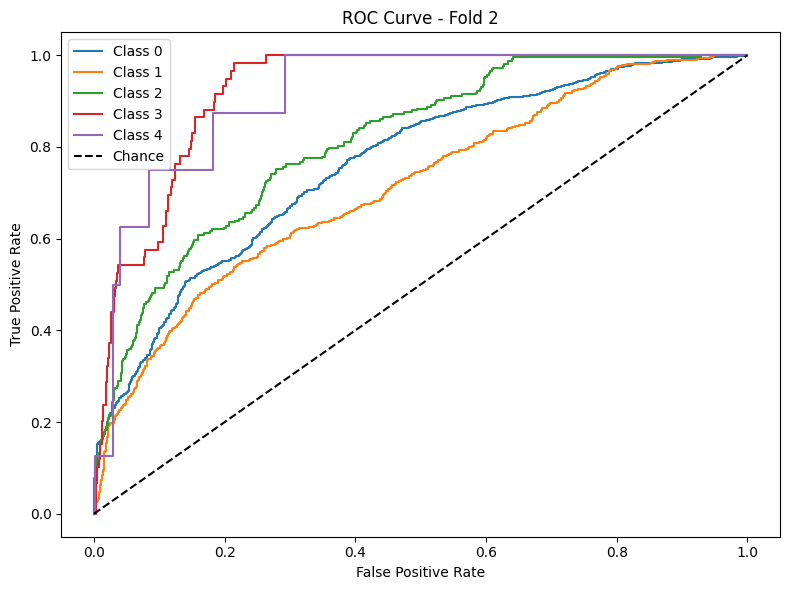

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


987/987 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5651 - loss: 1.2396 - val_accuracy: 0.5608 - val_loss: 1.0176
Epoch 2/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6563 - loss: 0.8472 - val_accuracy: 0.5549 - val_loss: 0.9760
Epoch 3/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6756 - loss: 0.8010 - val_accuracy: 0.5619 - val_loss: 0.9988
Epoch 4/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6837 - loss: 0.7783 - val_accuracy: 0.5844 - val_loss: 0.9783
Epoch 5/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6830 - loss: 0.7731 - val_accuracy: 0.6080 - val_loss: 0.9608
Epoch 6/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6924 - loss: 0.7596 - val_accuracy: 0.5457 - val_loss: 0.9842
Epoch 7/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6970 - loss: 0.7422 - val_accuracy: 0.5707 - val_loss: 0.9962
Epoch 8/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6973 - loss: 0.7450 - val_accuracy: 0.5420 - val

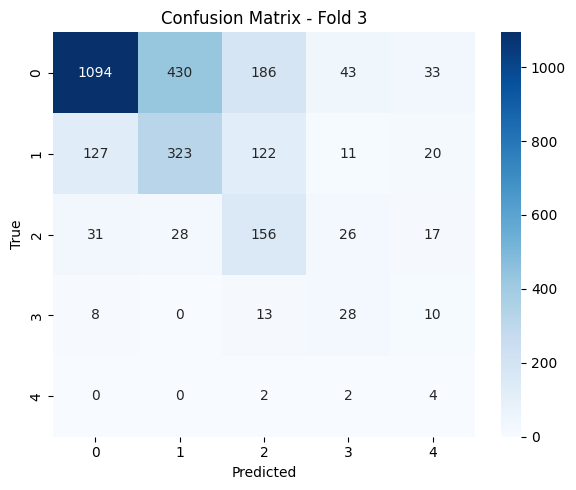

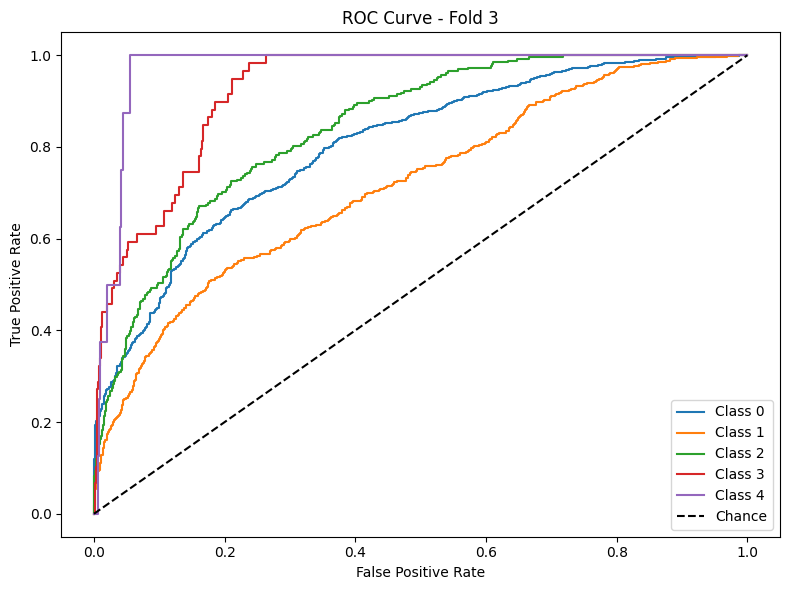

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


987/987 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5453 - loss: 1.2757 - val_accuracy: 0.5361 - val_loss: 1.0033
Epoch 2/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6442 - loss: 0.8657 - val_accuracy: 0.5715 - val_loss: 0.9498
Epoch 3/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6635 - loss: 0.8299 - val_accuracy: 0.6175 - val_loss: 0.8935
Epoch 4/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6692 - loss: 0.8087 - val_accuracy: 0.5789 - val_loss: 0.9513
Epoch 5/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6821 - loss: 0.7861 - val_accuracy: 0.5634 - val_loss: 0.9647
Epoch 6/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6837 - loss: 0.7801 - val_accuracy: 0.6371 - val_loss: 0.8495
Epoch 7/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6875 - loss: 0.7639 - val_accuracy: 0.6223 - val_loss: 0.8852
Epoch 8/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6932 - loss: 0.7639 - val_accuracy: 0.6120 - val_

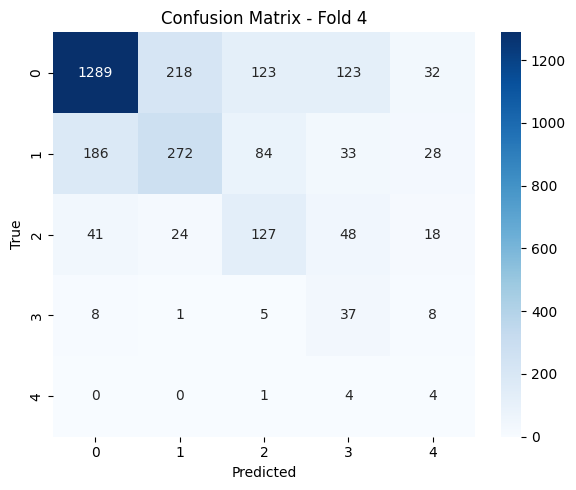

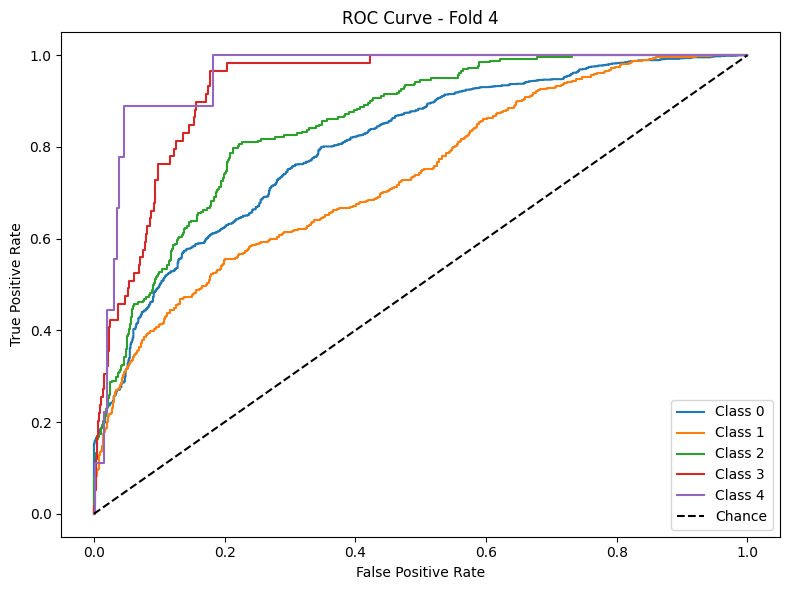

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


987/987 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5804 - loss: 1.1849 - val_accuracy: 0.4867 - val_loss: 1.0667
Epoch 2/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6748 - loss: 0.8006 - val_accuracy: 0.5925 - val_loss: 0.9749
Epoch 3/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6802 - loss: 0.7831 - val_accuracy: 0.6153 - val_loss: 0.9154
Epoch 4/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6965 - loss: 0.7464 - val_accuracy: 0.5667 - val_loss: 0.9756
Epoch 5/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6952 - loss: 0.7419 - val_accuracy: 0.6046 - val_loss: 0.9170
Epoch 6/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7077 - loss: 0.7247 - val_accuracy: 0.6054 - val_loss: 0.9485
Epoch 7/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7071 - loss: 0.7168 - val_accuracy: 0.6069 - val_loss: 0.9068
Epoch 8/50
987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7155 - loss: 0.7066 - val_accuracy: 0.5914 - val_

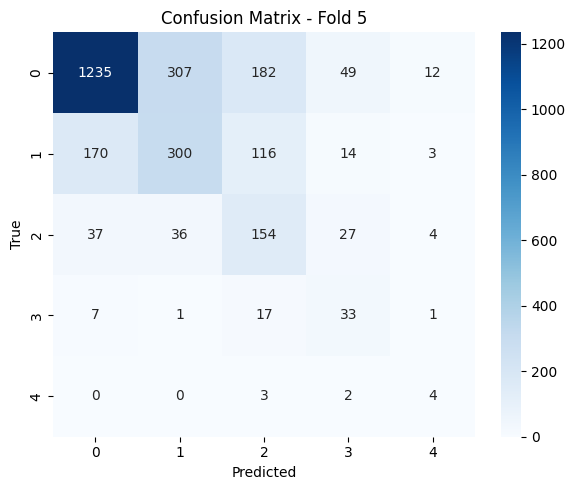

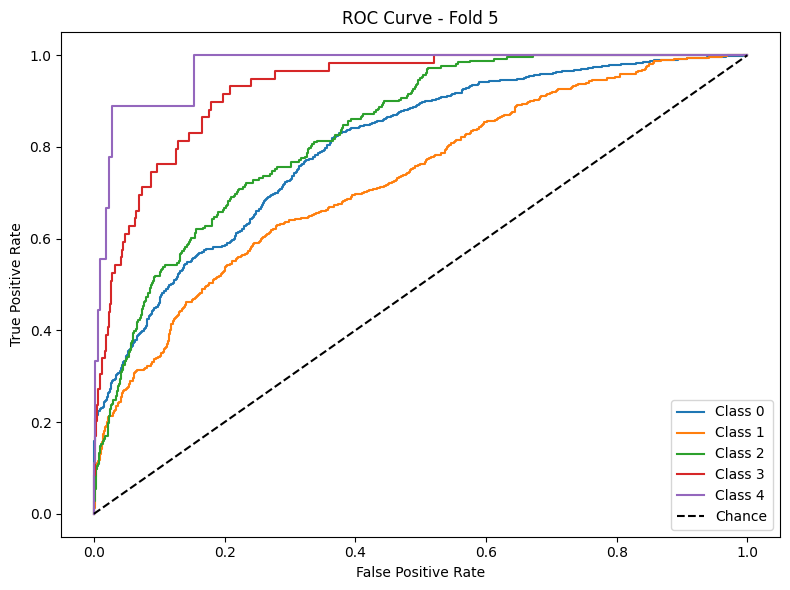


Average Accuracy: 0.6129
Average F1 Macro: 0.4030
Average AUC: 0.8455

=== Training Phase 2 ===
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


824/824 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.5531 - loss: 1.3538 - val_accuracy: 0.5783 - val_loss: 1.0854
Epoch 2/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6533 - loss: 0.8658 - val_accuracy: 0.6062 - val_loss: 0.9920
Epoch 3/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6721 - loss: 0.8280 - val_accuracy: 0.5562 - val_loss: 1.0389
Epoch 4/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6869 - loss: 0.7848 - val_accuracy: 0.5898 - val_loss: 1.0315
Epoch 5/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6856 - loss: 0.7887 - val_accuracy: 0.6208 - val_loss: 0.9398
Epoch 6/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6868 - loss: 0.7695 - val_accuracy: 0.6053 - val_loss: 0.9825
Epoch 7/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6940 - loss: 0.7540 - val_accuracy: 0.6239 - val_loss: 0.9521
Epoch 8/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6995 - loss: 0.7478 - val_accuracy: 0.6080 - val

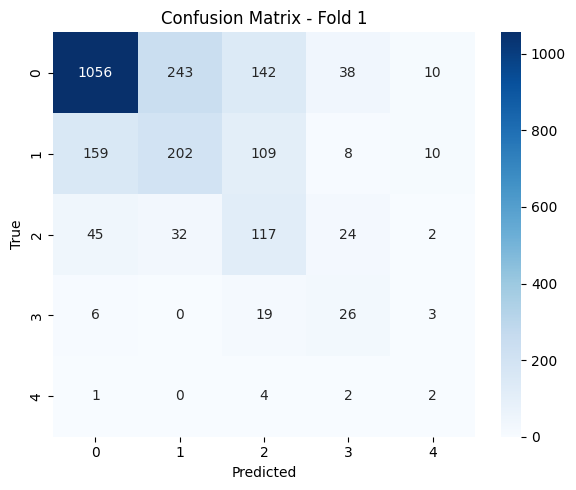

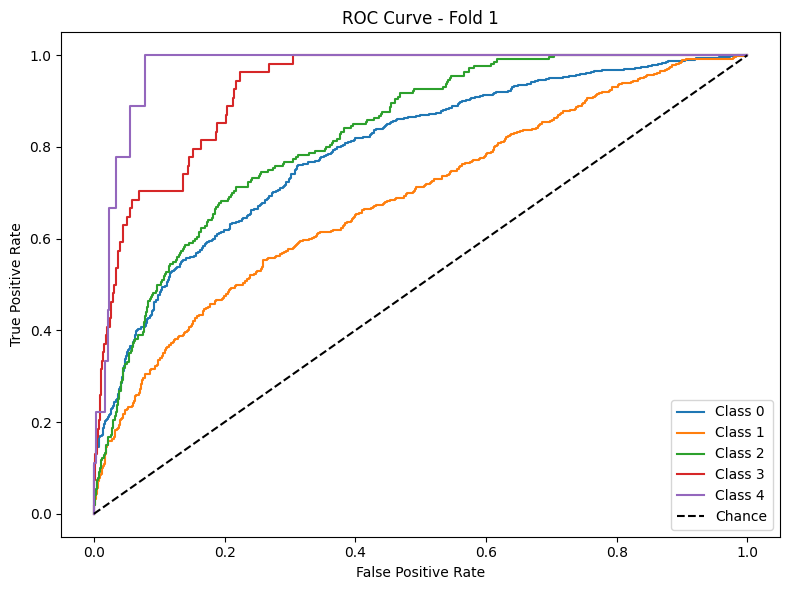

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


824/824 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.5406 - loss: 1.4119 - val_accuracy: 0.5040 - val_loss: 1.2662
Epoch 2/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6625 - loss: 0.8489 - val_accuracy: 0.5832 - val_loss: 1.0300
Epoch 3/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6859 - loss: 0.7796 - val_accuracy: 0.5704 - val_loss: 1.0641
Epoch 4/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6958 - loss: 0.7634 - val_accuracy: 0.5752 - val_loss: 0.9926
Epoch 5/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7058 - loss: 0.7505 - val_accuracy: 0.6217 - val_loss: 0.9152
Epoch 6/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7127 - loss: 0.7231 - val_accuracy: 0.6235 - val_loss: 0.9312
Epoch 7/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7115 - loss: 0.7216 - val_accuracy: 0.6035 - val_loss: 0.9914
Epoch 8/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7188 - loss: 0.7074 - val_accuracy: 0.6173 - val

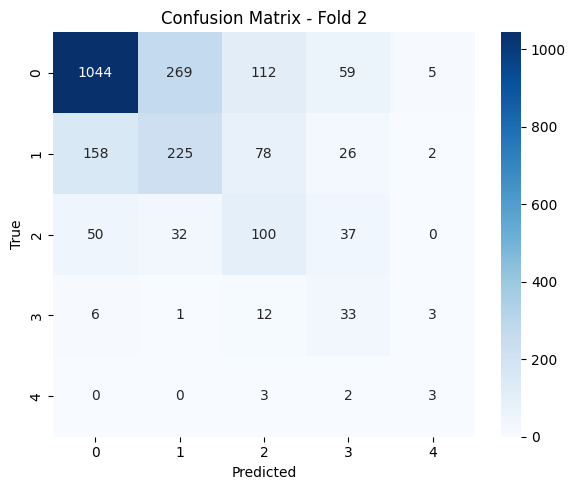

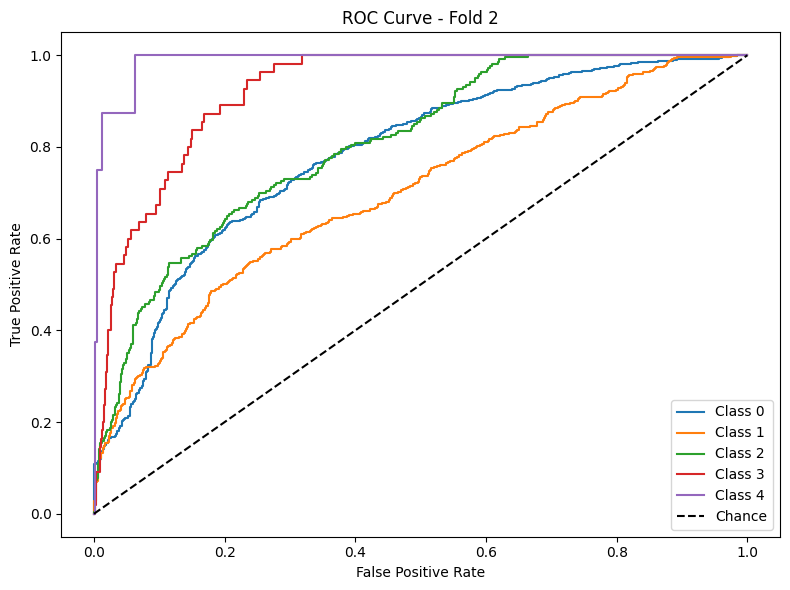

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


824/824 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.5532 - loss: 1.3744 - val_accuracy: 0.5131 - val_loss: 1.0946
Epoch 2/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6663 - loss: 0.8506 - val_accuracy: 0.5339 - val_loss: 1.0860
Epoch 3/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6862 - loss: 0.7929 - val_accuracy: 0.5874 - val_loss: 1.0291
Epoch 4/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6888 - loss: 0.7668 - val_accuracy: 0.5976 - val_loss: 1.0184
Epoch 5/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6966 - loss: 0.7580 - val_accuracy: 0.5613 - val_loss: 1.0302
Epoch 6/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7068 - loss: 0.7460 - val_accuracy: 0.5883 - val_loss: 0.9913
Epoch 7/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7051 - loss: 0.7417 - val_accuracy: 0.6166 - val_loss: 0.9422
Epoch 8/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7094 - loss: 0.7275 - val_accuracy: 0.6078 - val

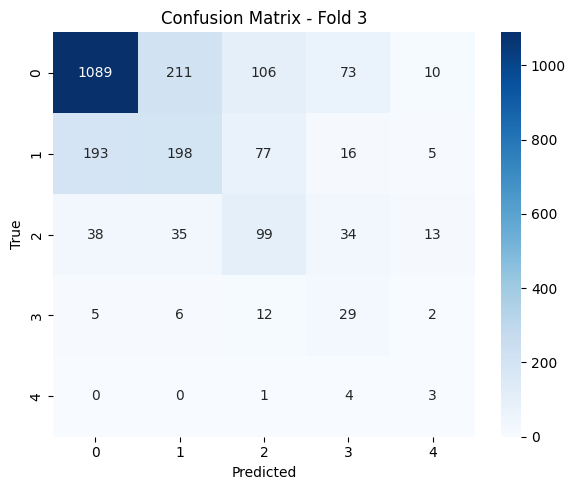

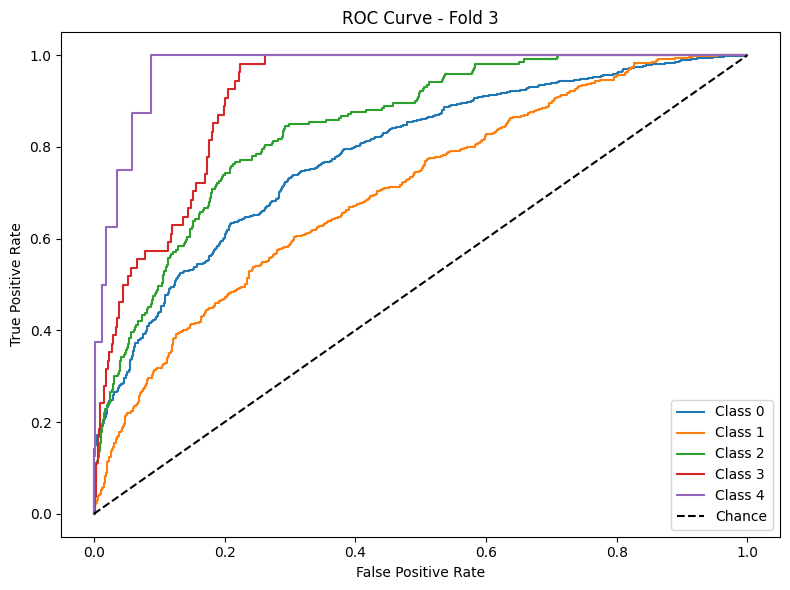

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.5567 - loss: 1.3209 - val_accuracy: 0.5693 - val_loss: 0.9607
Epoch 2/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6395 - loss: 0.8776 - val_accuracy: 0.5693 - val_loss: 0.9717
Epoch 3/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6640 - loss: 0.8375 - val_accuracy: 0.5741 - val_loss: 1.0376
Epoch 4/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6694 - loss: 0.8248 - val_accuracy: 0.5865 - val_loss: 0.9899
Epoch 5/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6799 - loss: 0.7984 - val_accuracy: 0.5662 - val_loss: 1.0122
Epoch 6/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6809 - loss: 0.7940 - val_accuracy: 0.6166 - val_loss: 0.9101
Epoch 7/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6880 - loss: 0.7662 - val_accuracy: 0.6335 - val_loss: 0.9058
Epoch 8/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6886 - loss: 0.7702 - val_accuracy: 0

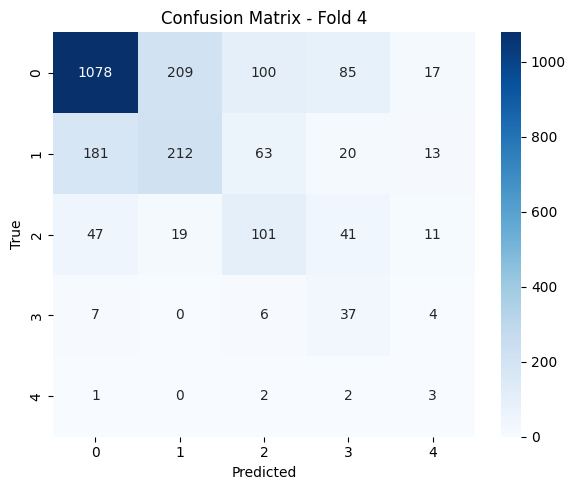

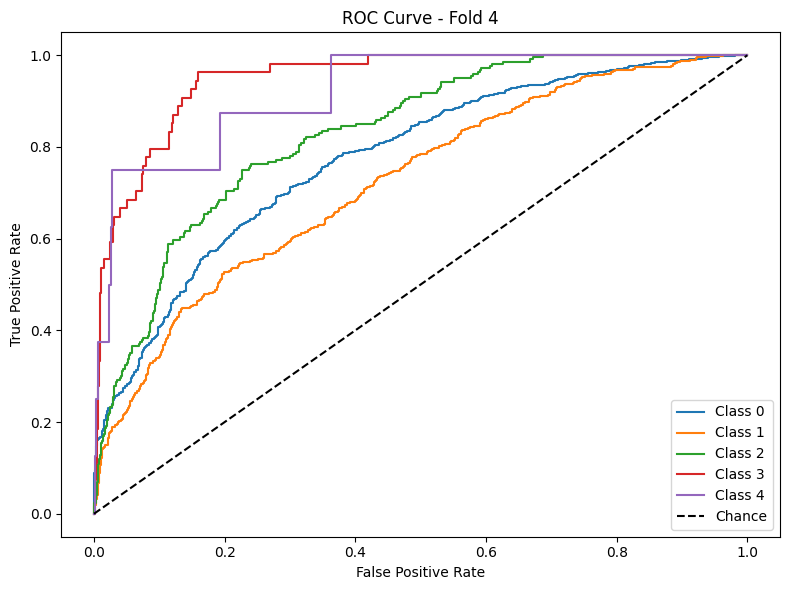

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


824/824 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.5680 - loss: 1.3166 - val_accuracy: 0.5325 - val_loss: 1.0738
Epoch 2/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6641 - loss: 0.8532 - val_accuracy: 0.5312 - val_loss: 1.1723
Epoch 3/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6809 - loss: 0.8043 - val_accuracy: 0.5901 - val_loss: 1.0178
Epoch 4/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6960 - loss: 0.7805 - val_accuracy: 0.5525 - val_loss: 1.0678
Epoch 5/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6978 - loss: 0.7714 - val_accuracy: 0.5914 - val_loss: 0.9848
Epoch 6/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7037 - loss: 0.7502 - val_accuracy: 0.6104 - val_loss: 0.9749
Epoch 7/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7145 - loss: 0.7270 - val_accuracy: 0.6078 - val_loss: 0.9272
Epoch 8/50
824/824 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7161 - loss: 0.7286 - val_accuracy: 0.5914 - val

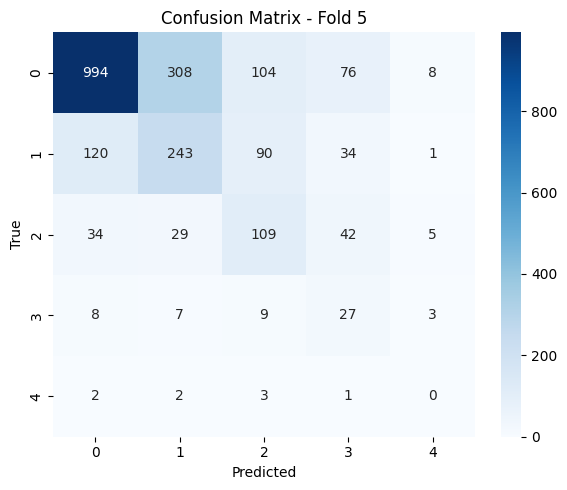

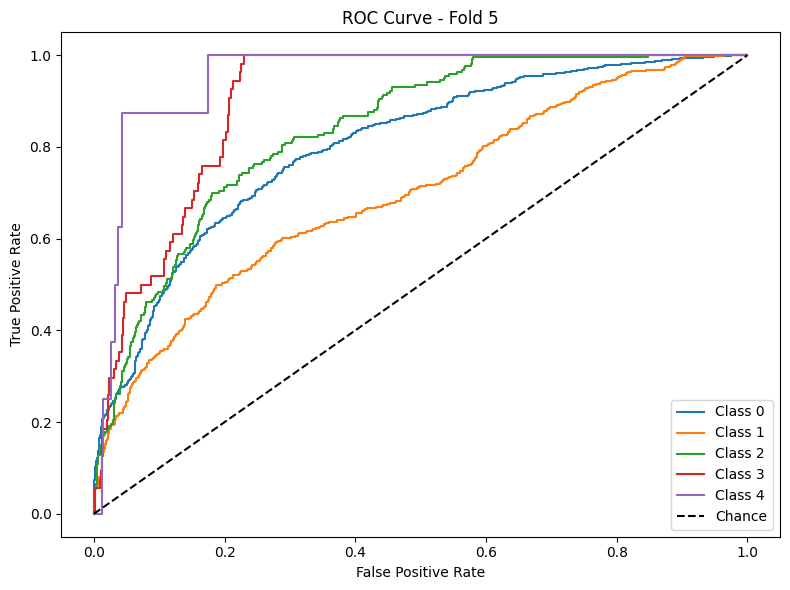


Average Accuracy: 0.6223
Average F1 Macro: 0.4040
Average AUC: 0.8404

=== Training Phase 3 ===
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


752/752 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.5587 - loss: 1.3552 - val_accuracy: 0.5993 - val_loss: 1.0260
Epoch 2/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6704 - loss: 0.8514 - val_accuracy: 0.5969 - val_loss: 1.0286
Epoch 3/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6822 - loss: 0.8053 - val_accuracy: 0.6205 - val_loss: 1.0364
Epoch 4/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6962 - loss: 0.7691 - val_accuracy: 0.6167 - val_loss: 1.0080
Epoch 5/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7028 - loss: 0.7515 - val_accuracy: 0.5776 - val_loss: 1.0495
Epoch 6/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7077 - loss: 0.7389 - val_accuracy: 0.5762 - val_loss: 1.1111
Epoch 7/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7105 - loss: 0.7176 - val_accuracy: 0.5935 - val_loss: 1.0319
Epoch 8/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7258 - loss: 0.7130 - val_accuracy: 0.5984 - val

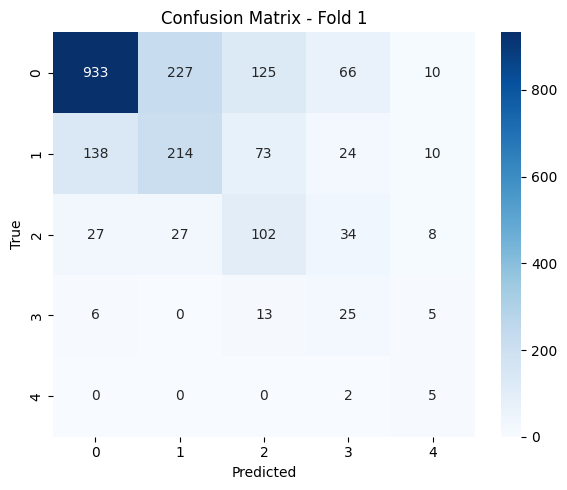

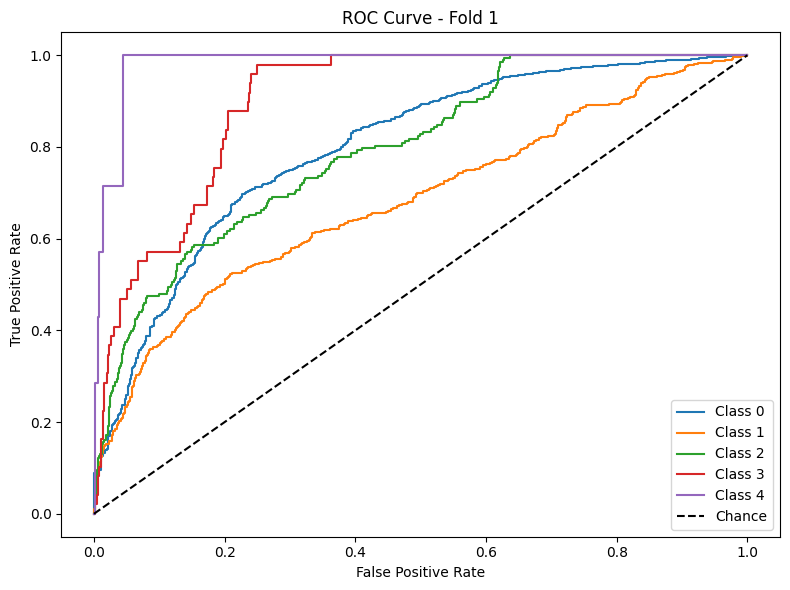

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


752/752 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.5607 - loss: 1.3661 - val_accuracy: 0.5473 - val_loss: 1.0207
Epoch 2/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6654 - loss: 0.8428 - val_accuracy: 0.5323 - val_loss: 1.0967
Epoch 3/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6850 - loss: 0.7959 - val_accuracy: 0.5497 - val_loss: 1.0389
Epoch 4/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6937 - loss: 0.7798 - val_accuracy: 0.5723 - val_loss: 0.9964
Epoch 5/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6986 - loss: 0.7701 - val_accuracy: 0.5458 - val_loss: 1.1481
Epoch 6/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7112 - loss: 0.7383 - val_accuracy: 0.6287 - val_loss: 0.9760
Epoch 7/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7176 - loss: 0.7251 - val_accuracy: 0.5873 - val_loss: 0.9377
Epoch 8/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7164 - loss: 0.7267 - val_accuracy: 0.5849 - val

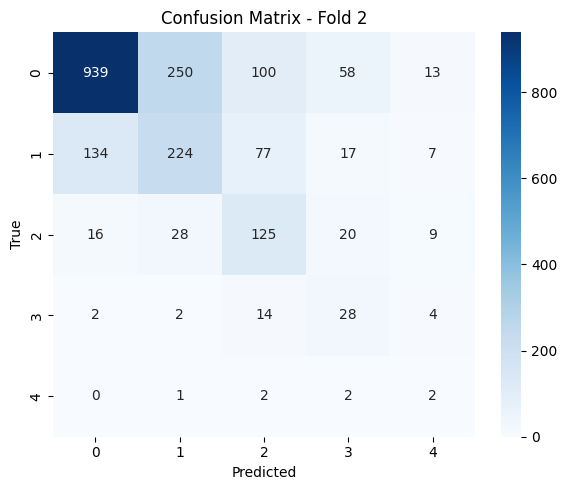

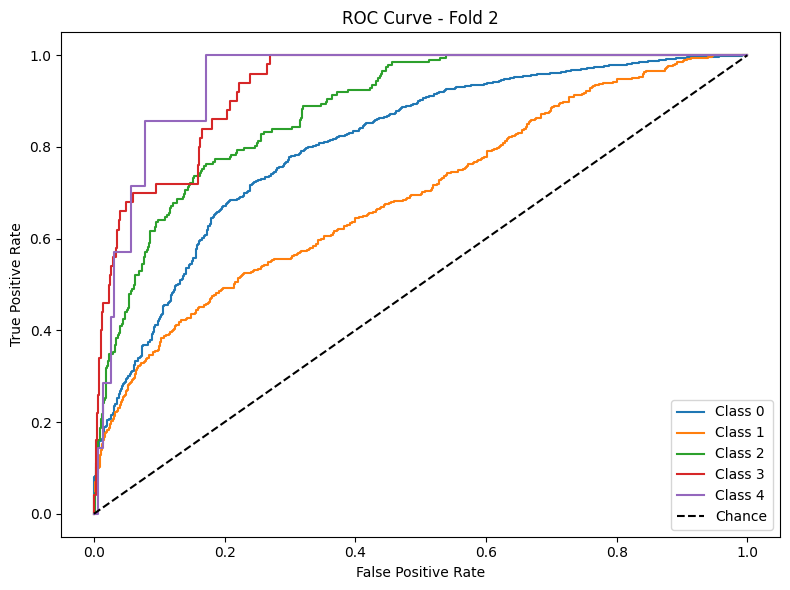

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


752/752 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.5550 - loss: 1.4286 - val_accuracy: 0.5771 - val_loss: 1.1057
Epoch 2/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6647 - loss: 0.8635 - val_accuracy: 0.5212 - val_loss: 1.1550
Epoch 3/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6723 - loss: 0.8202 - val_accuracy: 0.5627 - val_loss: 1.1119
Epoch 4/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6795 - loss: 0.7946 - val_accuracy: 0.5371 - val_loss: 1.1327
Epoch 5/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6992 - loss: 0.7552 - val_accuracy: 0.5771 - val_loss: 1.0654
Epoch 6/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6987 - loss: 0.7580 - val_accuracy: 0.5815 - val_loss: 1.0045
Epoch 7/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7037 - loss: 0.7469 - val_accuracy: 0.5878 - val_loss: 1.0179
Epoch 8/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7068 - loss: 0.7393 - val_accuracy: 0.5685 - val

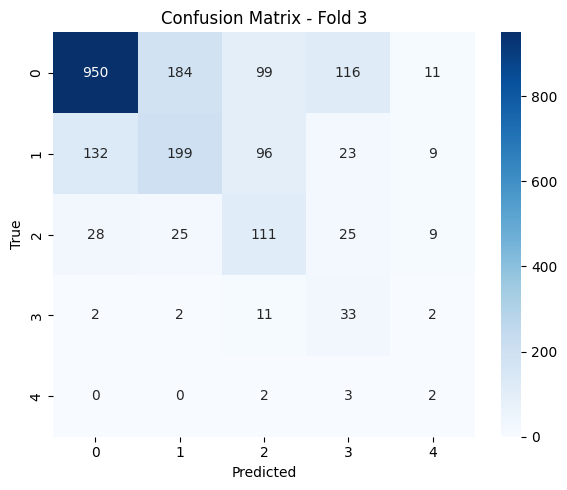

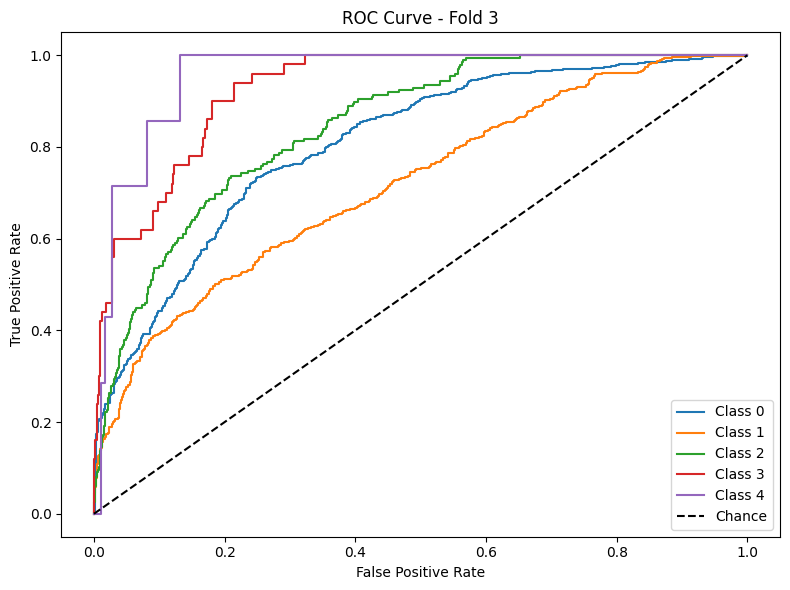

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


752/752 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.5589 - loss: 1.4829 - val_accuracy: 0.5603 - val_loss: 1.0511
Epoch 2/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6535 - loss: 0.8702 - val_accuracy: 0.5733 - val_loss: 1.0815
Epoch 3/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6780 - loss: 0.8265 - val_accuracy: 0.5526 - val_loss: 1.0923
Epoch 4/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6864 - loss: 0.7792 - val_accuracy: 0.6148 - val_loss: 0.9776
Epoch 5/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6902 - loss: 0.7789 - val_accuracy: 0.5767 - val_loss: 0.9942
Epoch 6/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6971 - loss: 0.7535 - val_accuracy: 0.5873 - val_loss: 1.0136
Epoch 7/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6977 - loss: 0.7454 - val_accuracy: 0.6085 - val_loss: 1.0110
Epoch 8/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7112 - loss: 0.7250 - val_accuracy: 0.5921 - val

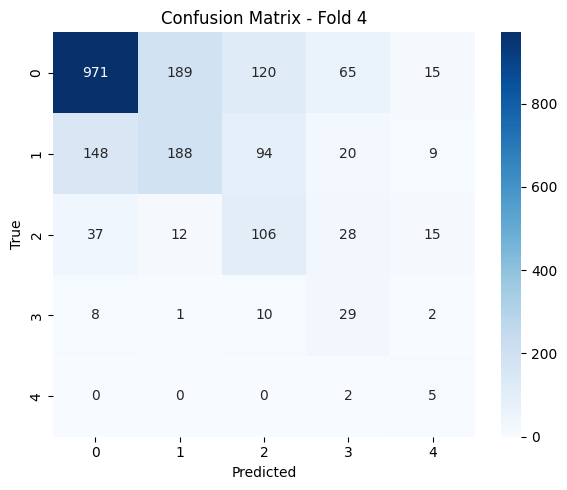

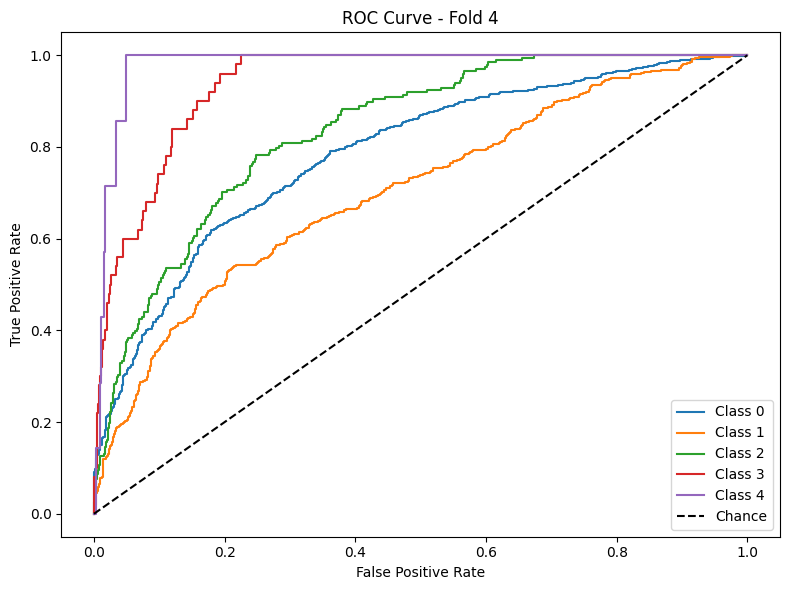

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


752/752 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.5505 - loss: 1.4237 - val_accuracy: 0.5133 - val_loss: 1.1280
Epoch 2/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6659 - loss: 0.8443 - val_accuracy: 0.5620 - val_loss: 1.1097
Epoch 3/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6901 - loss: 0.7896 - val_accuracy: 0.5721 - val_loss: 1.0820
Epoch 4/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6955 - loss: 0.7792 - val_accuracy: 0.5567 - val_loss: 1.1295
Epoch 5/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7029 - loss: 0.7464 - val_accuracy: 0.5977 - val_loss: 1.0514
Epoch 6/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7104 - loss: 0.7291 - val_accuracy: 0.6088 - val_loss: 0.9744
Epoch 7/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7116 - loss: 0.7378 - val_accuracy: 0.6155 - val_loss: 1.0106
Epoch 8/50
752/752 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7123 - loss: 0.7303 - val_accuracy: 0.6011 - val

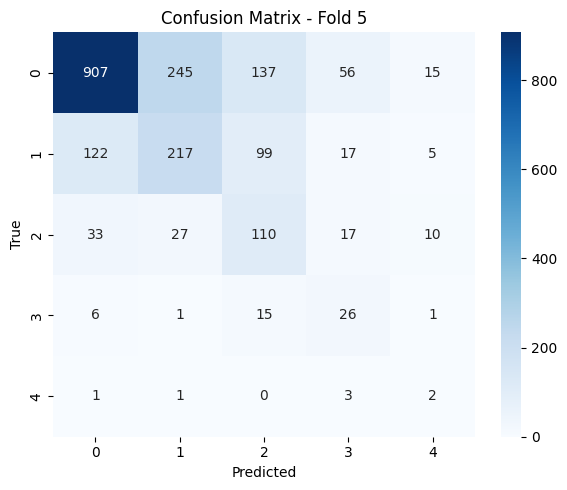

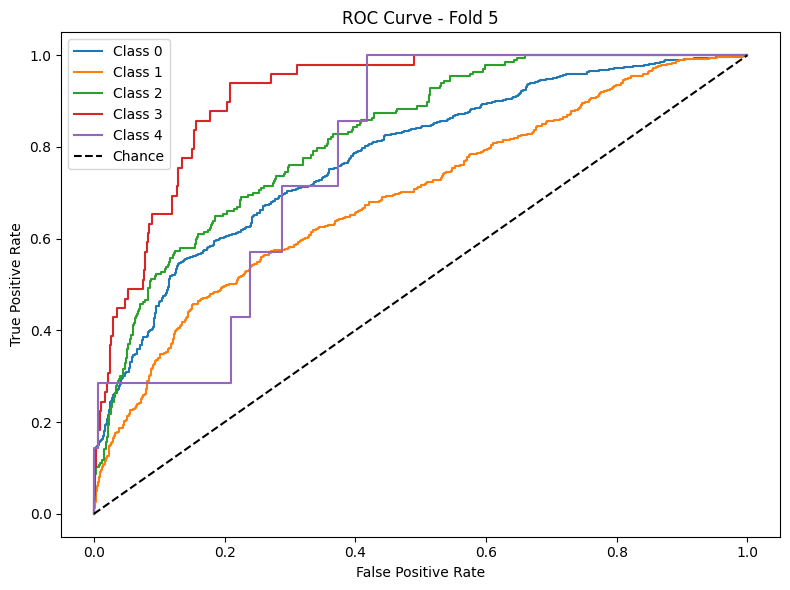


Average Accuracy: 0.6223
Average F1 Macro: 0.4140
Average AUC: 0.8361

=== Training Phase 4 ===
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


553/553 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5633 - loss: 1.4009 - val_accuracy: 0.2385 - val_loss: 1.6104
Epoch 2/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6679 - loss: 0.8437 - val_accuracy: 0.4522 - val_loss: 1.3459
Epoch 3/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6860 - loss: 0.8083 - val_accuracy: 0.5127 - val_loss: 1.2802
Epoch 4/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6987 - loss: 0.7688 - val_accuracy: 0.5757 - val_loss: 1.0532
Epoch 5/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7088 - loss: 0.7291 - val_accuracy: 0.5608 - val_loss: 1.2235
Epoch 6/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7103 - loss: 0.7343 - val_accuracy: 0.5166 - val_loss: 1.2130
Epoch 7/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7130 - loss: 0.7260 - val_accuracy: 0.4932 - val_loss: 1.2856
Epoch 8/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7206 - loss: 0.7088 - val_accuracy: 0.5367 - val

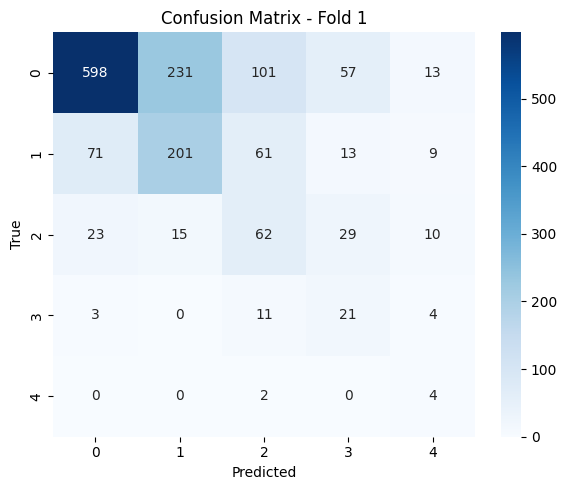

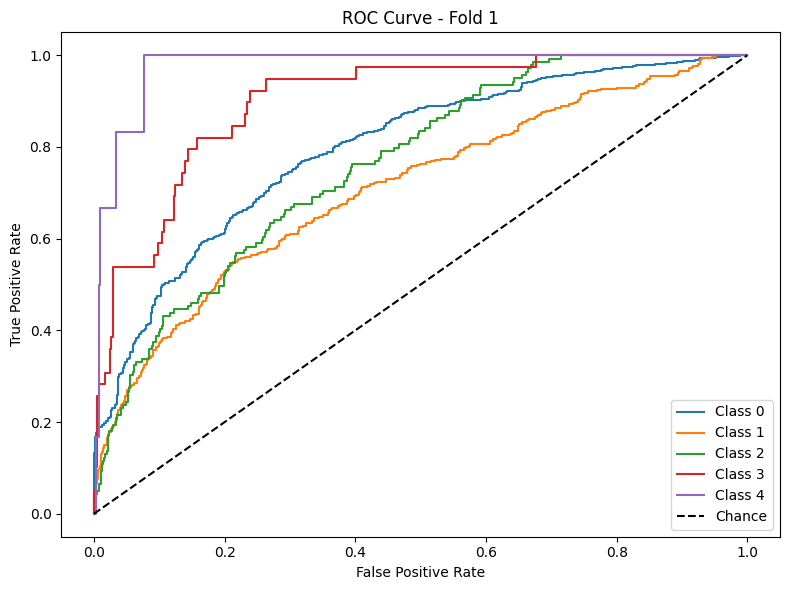

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.5447 - loss: 1.4248 - val_accuracy: 0.4477 - val_loss: 1.1953
Epoch 2/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6750 - loss: 0.8185 - val_accuracy: 0.5835 - val_loss: 1.0696
Epoch 3/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6919 - loss: 0.7860 - val_accuracy: 0.6121 - val_loss: 0.9839
Epoch 4/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7011 - loss: 0.7346 - val_accuracy: 0.5361 - val_loss: 1.1767
Epoch 5/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7078 - loss: 0.7232 - val_accuracy: 0.5939 - val_loss: 1.0974
Epoch 6/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7251 - loss: 0.6899 - val_accuracy: 0.5328 - val_loss: 1.0934
Epoch 7/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7204 - loss: 0.6938 - val_accuracy: 0.6511 - val_loss: 0.8772
Epoch 8/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7220 - loss: 0.6926 - val_accuracy: 0.6043 - val

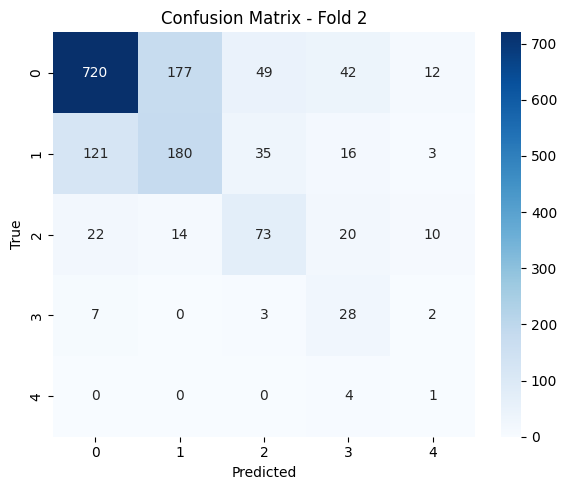

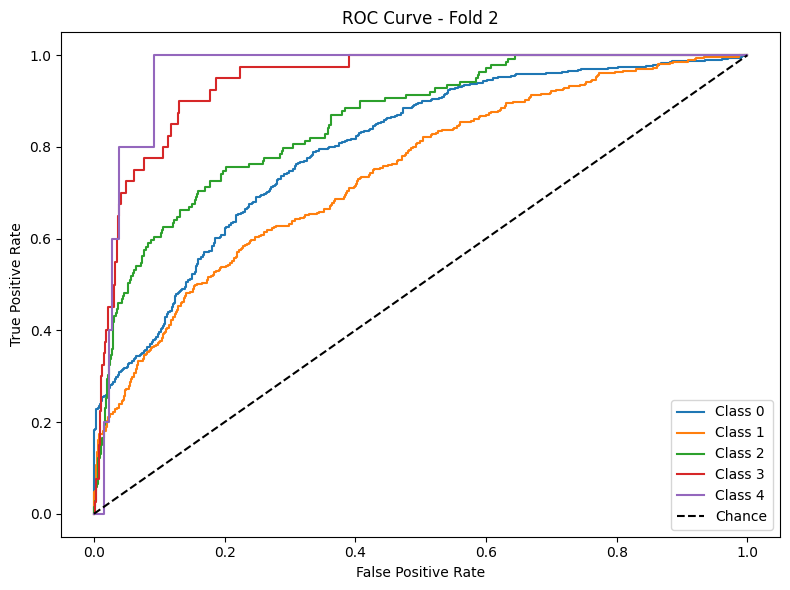

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


553/553 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5377 - loss: 1.4551 - val_accuracy: 0.5062 - val_loss: 1.1527
Epoch 2/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6570 - loss: 0.8607 - val_accuracy: 0.5211 - val_loss: 1.1323
Epoch 3/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6856 - loss: 0.7907 - val_accuracy: 0.5796 - val_loss: 0.9947
Epoch 4/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7016 - loss: 0.7668 - val_accuracy: 0.5854 - val_loss: 0.9705
Epoch 5/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7027 - loss: 0.7554 - val_accuracy: 0.5822 - val_loss: 1.0365
Epoch 6/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7126 - loss: 0.7374 - val_accuracy: 0.5393 - val_loss: 1.0967
Epoch 7/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7136 - loss: 0.7213 - val_accuracy: 0.6095 - val_loss: 0.9999
Epoch 8/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7153 - loss: 0.7239 - val_accuracy: 0.5133 - val

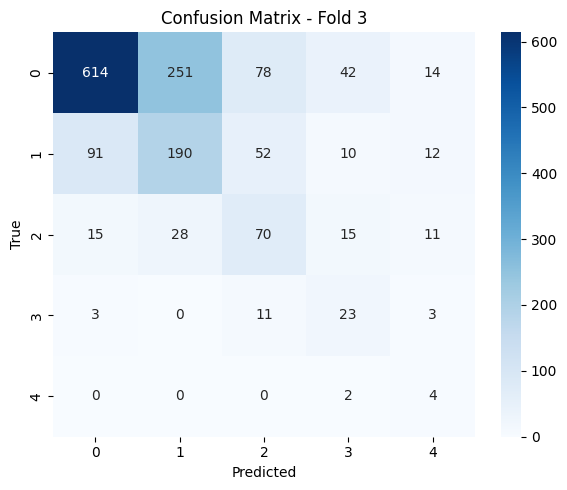

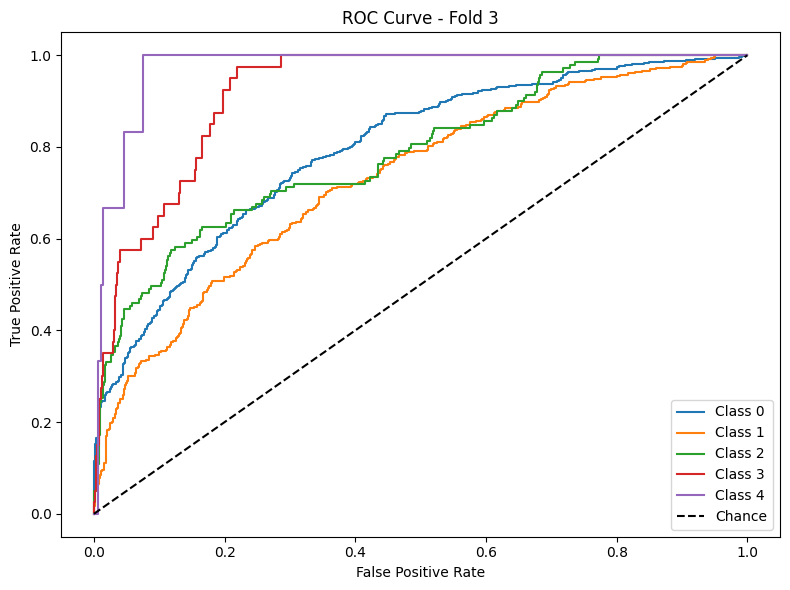

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


553/553 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.5385 - loss: 1.4715 - val_accuracy: 0.3368 - val_loss: 1.3255
Epoch 2/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6577 - loss: 0.8675 - val_accuracy: 0.5904 - val_loss: 1.0365
Epoch 3/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6775 - loss: 0.7983 - val_accuracy: 0.4434 - val_loss: 1.3038
Epoch 4/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6978 - loss: 0.7701 - val_accuracy: 0.5111 - val_loss: 1.1617
Epoch 5/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7049 - loss: 0.7679 - val_accuracy: 0.5624 - val_loss: 1.0288
Epoch 6/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7109 - loss: 0.7354 - val_accuracy: 0.6177 - val_loss: 0.9976
Epoch 7/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7165 - loss: 0.7286 - val_accuracy: 0.6021 - val_loss: 0.9781
Epoch 8/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7173 - loss: 0.7213 - val_accuracy: 0.5956 - val

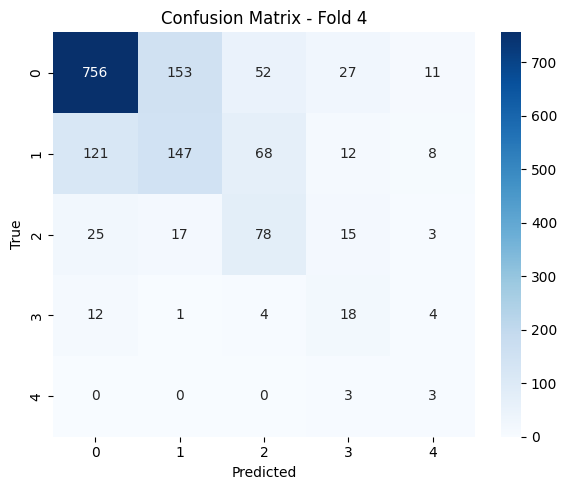

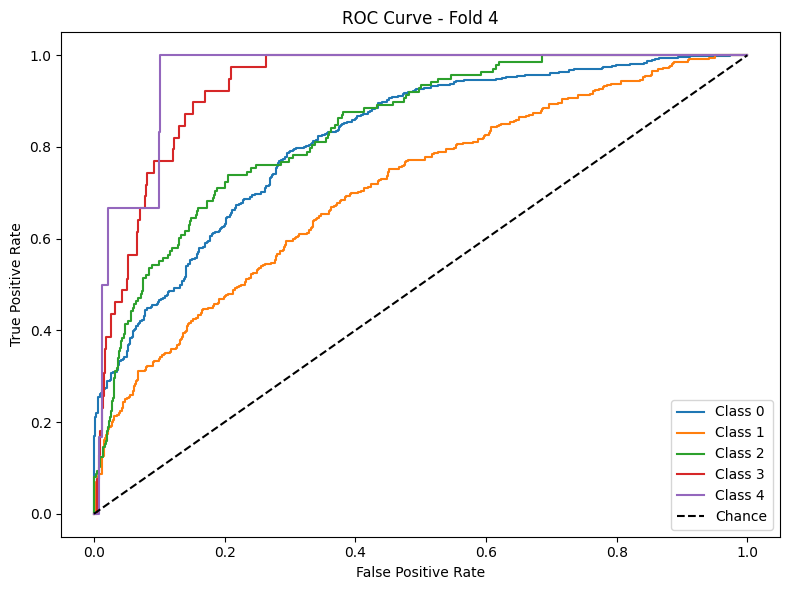

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


553/553 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5298 - loss: 1.4529 - val_accuracy: 0.3765 - val_loss: 1.3097
Epoch 2/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6595 - loss: 0.8390 - val_accuracy: 0.5137 - val_loss: 1.1193
Epoch 3/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6792 - loss: 0.7922 - val_accuracy: 0.6307 - val_loss: 1.0024
Epoch 4/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6914 - loss: 0.7598 - val_accuracy: 0.6047 - val_loss: 1.0468
Epoch 5/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7056 - loss: 0.7443 - val_accuracy: 0.6170 - val_loss: 0.9286
Epoch 6/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7077 - loss: 0.7229 - val_accuracy: 0.6027 - val_loss: 1.0234
Epoch 7/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7106 - loss: 0.7271 - val_accuracy: 0.6164 - val_loss: 0.9918
Epoch 8/50
553/553 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7152 - loss: 0.7119 - val_accuracy: 0.5683 - val

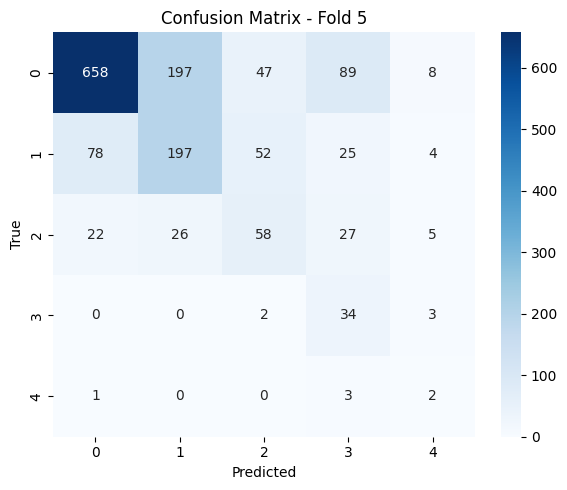

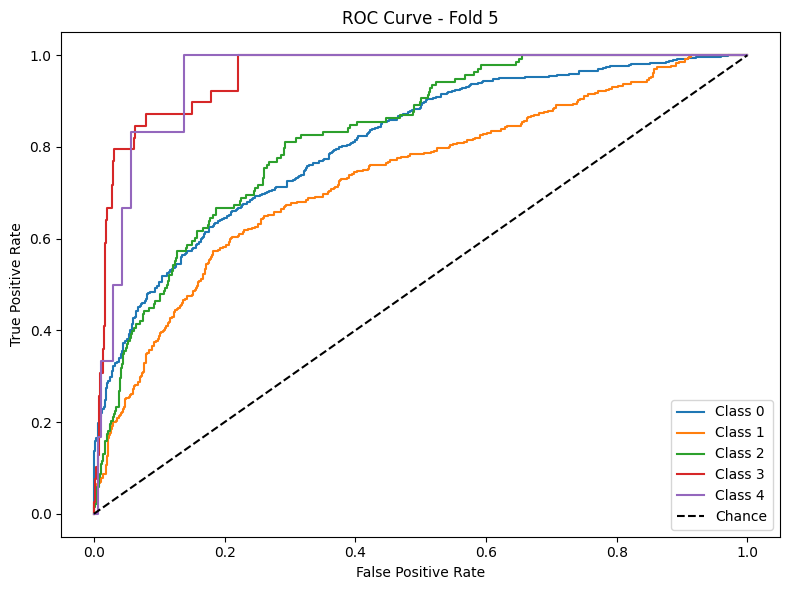


Average Accuracy: 0.6161
Average F1 Macro: 0.4209
Average AUC: 0.8474


In [7]:
phase_paths = [f"/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n=== Training Phase {i} ===")
    
    sample = True
    model, scaler, best_fold, metrics = train_phase(phase_path, sample=sample)
    
    temp = "sample" if sample else "no_sample"
    
    model.save(f"best_model_{temp}_phase{i}.keras")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    
    results[f"phase{i}"] = metrics

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.62      0.74       568
           1       0.11      0.41      0.17        63
           2       0.26      0.40      0.31        43
           3       0.29      0.13      0.18        15
           4       0.00      0.00      0.00         9

    accuracy                           0.57       698
   macro avg       0.31      0.31      0.28       698
weighted avg       0.77      0.57      0.64       698



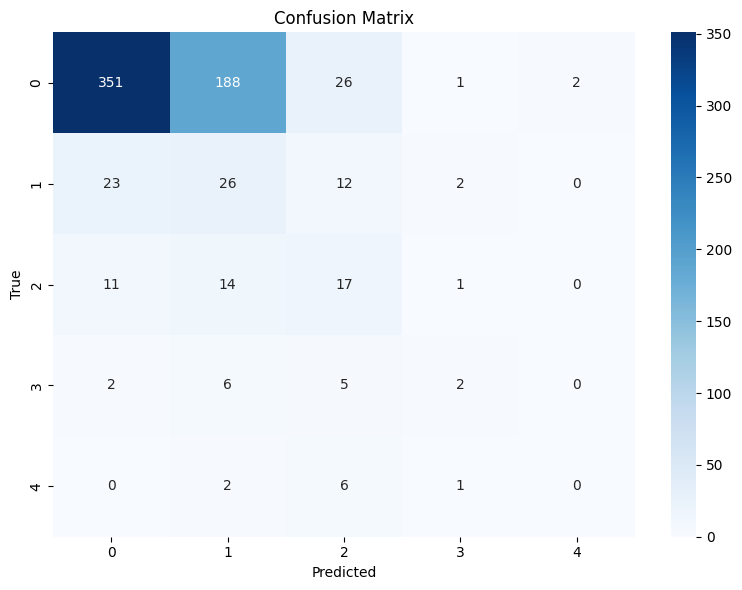


Test AUC (macro-average, OVR): 0.7414


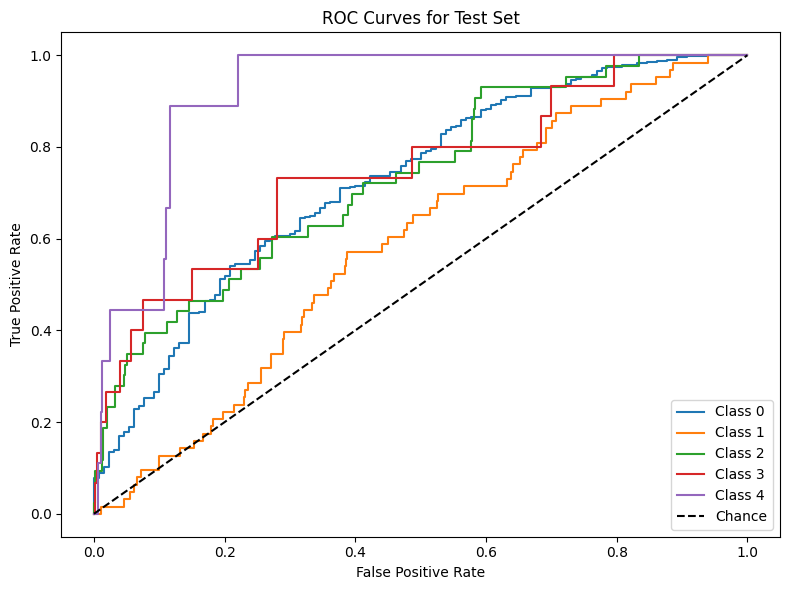

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.80      0.85       544
           1       0.14      0.22      0.17        59
           2       0.18      0.38      0.24        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.69       668
   macro avg       0.24      0.28      0.25       668
weighted avg       0.76      0.69      0.72       668



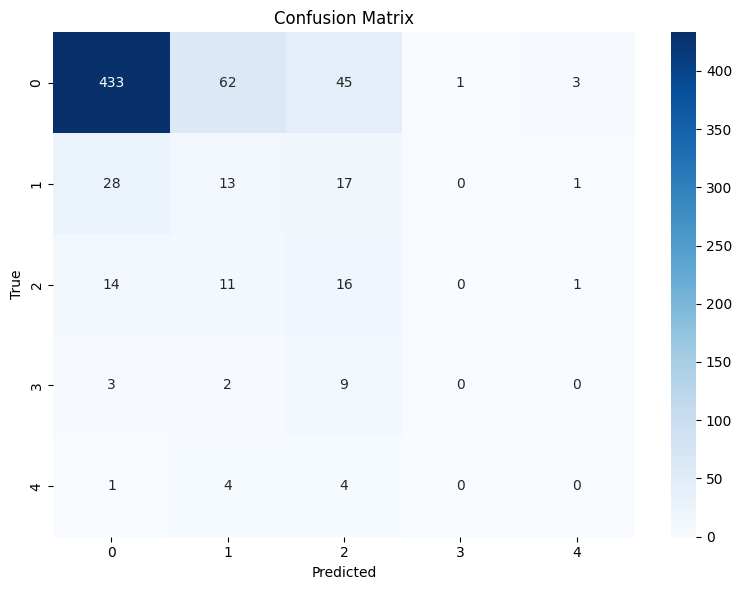


Test AUC (macro-average, OVR): 0.7204


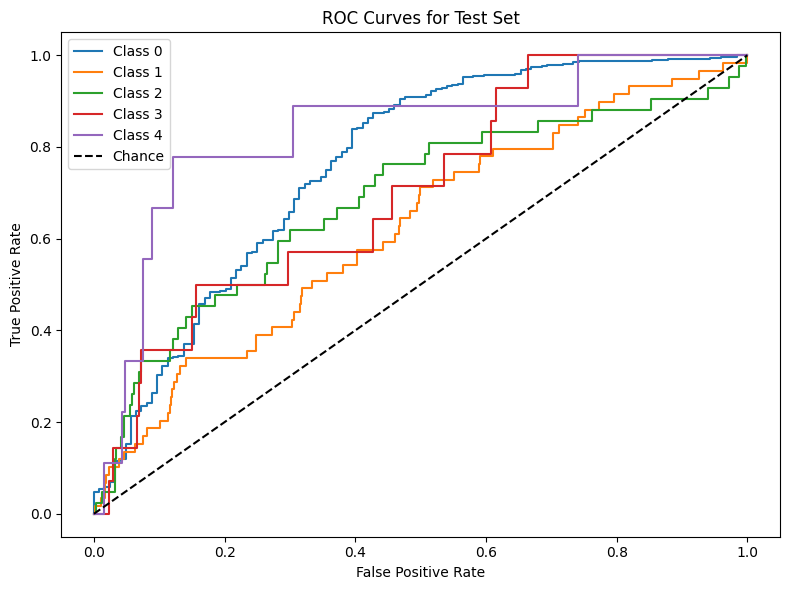

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       455
           1       0.20      0.27      0.23        52
           2       0.16      0.24      0.19        29
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.74       554
   macro avg       0.25      0.27      0.26       554
weighted avg       0.77      0.74      0.75       554



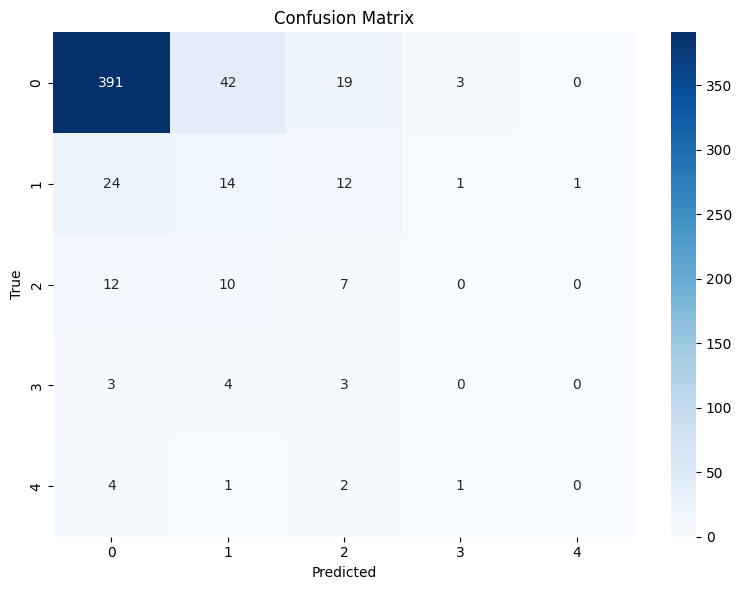


Test AUC (macro-average, OVR): 0.7549


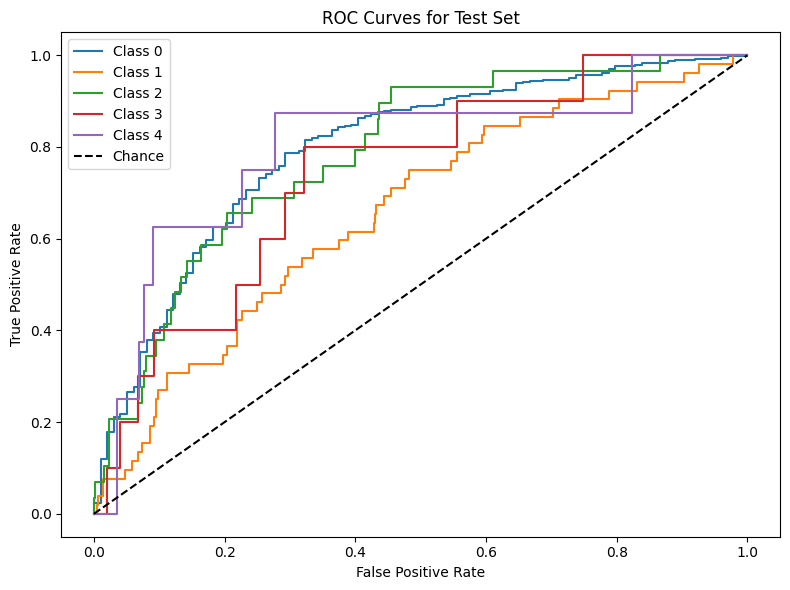

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.67      0.77       395
           1       0.10      0.38      0.16        40
           2       0.12      0.17      0.14        24
           3       0.50      0.10      0.17        10
           4       0.00      0.00      0.00         8

    accuracy                           0.60       477
   macro avg       0.32      0.26      0.25       477
weighted avg       0.76      0.60      0.66       477



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


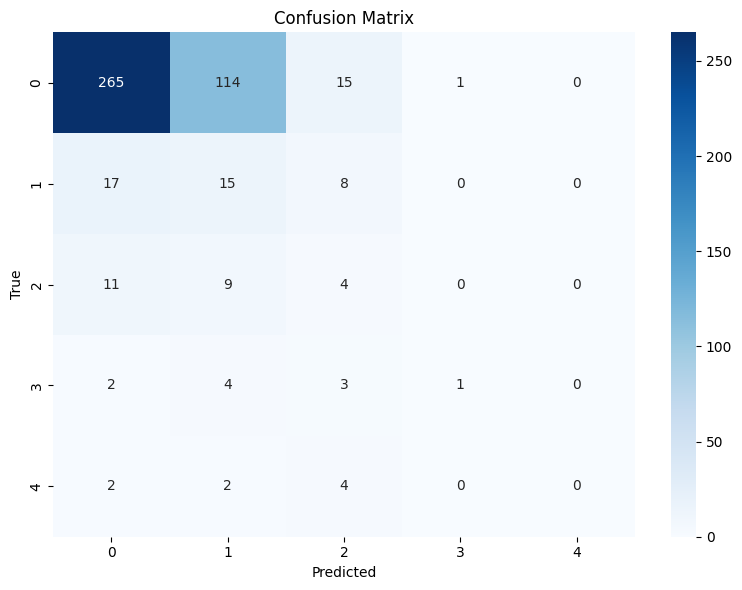


Test AUC (macro-average, OVR): 0.6580


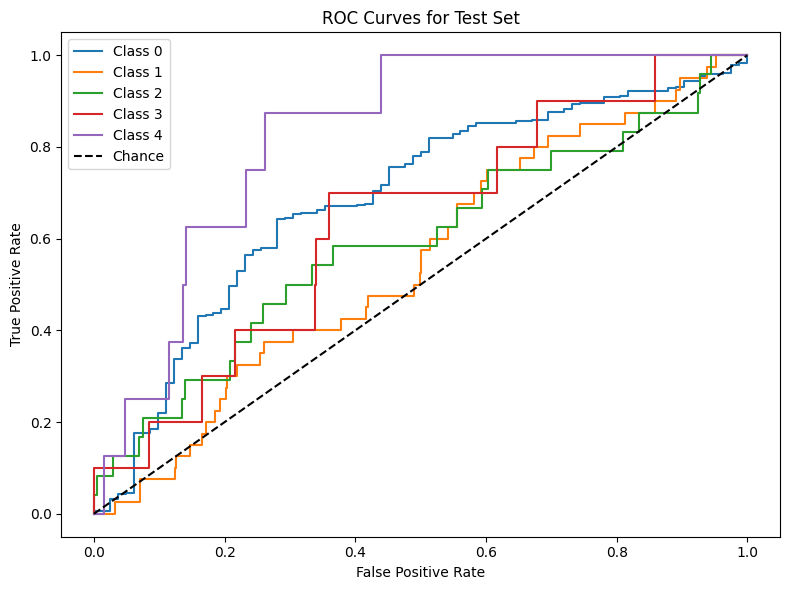

In [8]:
for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-using-node2vector/phase{i}/user_train_phase_{i}_test.csv'
    
    # Keras model
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.keras'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)